In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pickle
import torch
from torch.utils.data import Dataset, DataLoader
from scipy.stats import pearsonr
import pandas as pd
from sklearn.metrics import mean_squared_error
from nsp_with_index import BaseDataset4NSP, Dataset4NSP, INPUT_OUTPUT_PAIRS
import json
from typing import OrderedDict

Loading raw data - Data: (9166, 120, 6) Labels: (9166, 120, 3)
Unique activity labels -  [0. 1. 2. 3. 4. 5.]
Before normalization - Data shape: (9166, 120, 6) [-6.53186037e+00  1.09563701e+00  7.50957234e+00 -9.42993150e-03
 -8.63647463e-03 -1.58691408e-03]
After normalization - Data: (9166, 120, 6) Labels: (9166, 120, 3) [-0.66651636  0.1117997   0.76628289 -0.00942993 -0.00863647 -0.00158691]

Normalized Samples
[-0.61816811  0.1017263   0.81249097 -0.00270081  0.00247192 -0.00222778]
[-0.61558128  0.10407023  0.81467703 -0.00280762  0.00930786 -0.00340271]
[-0.61699007  0.10407024  0.81696024  0.00296021  0.01091003 -0.00820923]


In [2]:
BATCH_SIZE = 32
ACTIVITY_NAMES = {0:"bike", 1:"sit", 2:"downstairs", 3:"upstairs",4:"stand", 5:"walk"}

def load_data():
    """Load all required data saved by nsp_with_index.py"""
    print("Loading data...")
    
    # Load the raw and normalized data
    data = np.load("dataset/hhar/data_20_120.npy")
    labels = np.load("dataset/hhar/label_20_120.npy")
    normalized_data = np.load("dataset/hhar/normalized_data_20_120.npy")
    
    # Load processed data created during training
    filtered_data = np.load("processed_data/filtered_data.npy")
    
    # Load indices saved as pickle files
    with open("processed_data/kept_indices.pkl", 'rb') as f:
        kept_indices = pickle.load(f)
    
    # Load splits info
    split_info = np.load("splits/instance_level_splits.npy", allow_pickle=True).item()
    
    print(f"Data loaded successfully!")
    print(f"Data shapes - Raw: {data.shape}, Labels: {labels.shape}")
    print(f"Normalized: {normalized_data.shape}, Filtered: {filtered_data.shape}")
    
    return data, labels, normalized_data, filtered_data, kept_indices, split_info

def load_trained_model_predictions(input_len, pred_len, model_type="lstm"):
    """Load predictions from trained models"""
    config_dir = f"{model_type}_nsp/input_{input_len}_pred_{pred_len}"
    model_name = f"{model_type}_nsp_{input_len}_{pred_len}"
    
    try:
        predictions = np.load(f"{config_dir}/{model_name}_predictions.npy")
        actuals = np.load(f"{config_dir}/{model_name}_actuals.npy")
        test_pairs = np.load(f"{config_dir}/{model_name}_test_pairs.npy")
        
        print(f"Loaded {model_type.upper()} predictions for {input_len}->{pred_len}")
        print(f"Shapes - Predictions: {predictions.shape}, Actuals: {actuals.shape}")
        
        return predictions, actuals, test_pairs
    except FileNotFoundError as e:
        print(f"Error loading {model_type} predictions: {e}")
        return None, None, None

In [3]:
# Baseline Models

def linear_regression_predict(input_seq, pred_len):
    """Linear regression prediction for each feature"""
    predictions = np.zeros((pred_len, 6))
    
    for feature in range(6):
        x = np.arange(len(input_seq))
        y = input_seq[:, feature]
        
        # Handle NaN values
        valid_indices = ~np.isnan(y)
        if np.sum(valid_indices) < 2:  # Need at least 2 points for regression
            predictions[:, feature] = np.nanmean(y) if not np.all(np.isnan(y)) else 0
            continue
            
        x_valid = x[valid_indices]
        y_valid = y[valid_indices]
        
        # Calculate linear regression coefficients
        A = np.vstack([x_valid, np.ones(len(x_valid))]).T
        m, c = np.linalg.lstsq(A, y_valid, rcond=None)[0]
        
        # Predict future values
        for i in range(pred_len):
            predictions[i, feature] = m * (len(input_seq) + i) + c
            
    return predictions

def polynomial_regression_predict(input_seq, pred_len, degree=2):
    """Polynomial regression prediction for each feature"""
    predictions = np.zeros((pred_len, 6))
    
    for feature in range(6):
        x = np.arange(len(input_seq))
        y = input_seq[:, feature]
        
        # Handle NaN values
        valid_indices = ~np.isnan(y)
        if np.sum(valid_indices) <= degree:  # Need more points than polynomial degree
            predictions[:, feature] = np.nanmean(y) if not np.all(np.isnan(y)) else 0
            continue
            
        x_valid = x[valid_indices]
        y_valid = y[valid_indices]
        
        try:
            # Fit polynomial coefficients
            coeffs = np.polyfit(x_valid, y_valid, degree)
            poly = np.poly1d(coeffs)
            
            # Predict future values
            for i in range(pred_len):
                predictions[i, feature] = poly(len(input_seq) + i)
        except:
            # Fallback if fitting fails
            mean_val = np.nanmean(y_valid)
            predictions[:, feature] = mean_val
            
    return predictions

def kalman_predict(input_seq, pred_len, process_noise=0.01, measurement_noise=0.1):
    """Kalman filter prediction with constant velocity model"""
    predictions = np.zeros((pred_len, 6))
    
    for feature in range(6):
        # Get feature data
        y = input_seq[:, feature]
        
        # Handle NaN values
        valid_indices = ~np.isnan(y)
        if np.sum(valid_indices) < 2:
            predictions[:, feature] = np.nanmean(y) if not np.all(np.isnan(y)) else 0
            continue
            
        y_valid = y[valid_indices]
        
        # Initialize Kalman filter parameters
        # State: [position, velocity]
        x = np.array([y_valid[0], 0.0])  
        P = np.eye(2)  # Initial covariance
        
        # Process noise (affects prediction uncertainty)
        Q = np.eye(2) * process_noise
        
        # Measurement noise (affects how much we trust new measurements)
        R = measurement_noise
        
        # State transition matrix (constant velocity model)
        F = np.array([[1, 1], [0, 1]])
        
        # Measurement matrix (we only measure position, not velocity)
        H = np.array([1, 0]).reshape(1, 2)
        
        # Process all input data points
        for z in y_valid[1:]:
            # Prediction step
            x_pred = F @ x
            P_pred = F @ P @ F.T + Q
            
            # Update step
            K = P_pred @ H.T @ np.linalg.inv(H @ P_pred @ H.T + R)
            x = x_pred + K @ (np.array([z]) - H @ x_pred)
            P = (np.eye(2) - K @ H) @ P_pred
        
        # Predict future steps
        for i in range(pred_len):
            # For future predictions, we only do the prediction step
            x = F @ x
            P = F @ P @ F.T + Q
            
            # Store the position component of the state
            predictions[i, feature] = x[0]
            
    return predictions

def generate_baseline_predictions(baseline_func, test_loader, pred_len):
    """Generate predictions using a baseline model"""
    all_preds = []
    all_actuals = []
    
    for batch in test_loader:
        input_seq, _, _, target_seq = batch
        
        # Convert to numpy
        inputs = input_seq.numpy()
        targets = target_seq.numpy()
        
        # Generate predictions for each sequence in batch
        batch_preds = []
        for seq in inputs:
            pred = baseline_func(seq, pred_len)
            batch_preds.append(pred)
        
        all_preds.extend(batch_preds)
        all_actuals.extend(targets)
    
    return np.array(all_preds), np.array(all_actuals)

In [4]:
def calculate_metrics(predictions, actuals):
    """Calculate MSE, MAPE, and Pearson correlation"""

    # overall metrics

    # MSE (Mean Squared Error) 
    overall_mse = mean_squared_error(actuals.flatten(), predictions.flatten())
    
    # Mean Absolute Percentage Error  (MAPE)
    # Handle MAPE calculation (avoid division by zero)
    non_zero = actuals.flatten() != 0
    if np.any(non_zero):
        overall_mape = np.mean(np.abs((actuals.flatten()[non_zero] - predictions.flatten()[non_zero]) / 
                                       actuals.flatten()[non_zero])) * 100
    else:
        overall_mape = np.nan
    
    # Pearson correlation
    try:
        overall_pearson = pearsonr(predictions.flatten(), actuals.flatten())[0]
    except:
        overall_pearson = np.nan
    
    # Feature-specific metrics
    feature_metrics = {
        'mse': [],
        'mape': [],
        'pearson': []
    }
    
    for feature in range(6):
        # Extract feature values
        pred_feature = predictions[..., feature].flatten()
        actual_feature = actuals[..., feature].flatten()
        
        # MSE
        mse = mean_squared_error(actual_feature, pred_feature)
        
        # MAPE
        non_zero = actual_feature != 0
        if np.any(non_zero):
            mape = np.mean(np.abs((actual_feature[non_zero] - pred_feature[non_zero]) / 
                                   actual_feature[non_zero])) * 100
        else:
            mape = np.nan
        
        # Pearson
        try:
            pearson = pearsonr(pred_feature, actual_feature)[0]
        except:
            pearson = np.nan
        
        feature_metrics['mse'].append(mse)
        feature_metrics['mape'].append(mape)
        feature_metrics['pearson'].append(pearson)
    
    metrics = {
        'overall_mse': overall_mse,
        'overall_mape': overall_mape,
        'overall_pearson': overall_pearson,
        'mse': feature_metrics['mse'],
        'mape': feature_metrics['mape'],
        'pearson': feature_metrics['pearson']
    }
    
    return metrics

def calculate_metrics_by_activity(predictions, actuals, pair_to_activity):
    """Calculate metrics for each activity class"""
    # Get unique activity classes
    activity_classes = np.unique(list(pair_to_activity.values()))
    
    # Create a dictionary to store results by activity
    activity_results = {}
    
    # Map flat indices to their activities
    pair_indices = list(pair_to_activity.keys())
    
    for activity in activity_classes:
        # Find which predictions correspond to this activity
        activity_indices = [i for i, idx in enumerate(pair_indices) 
                          if pair_to_activity.get(idx) == activity]
        
        if not activity_indices:
            print(f"Warning: No test data for activity {activity}")
            continue
        
        # Extract predictions and actuals for this activity
        activity_preds = predictions[activity_indices]
        activity_actuals = actuals[activity_indices]
        
        # Calculate metrics
        metrics = calculate_metrics(activity_preds, activity_actuals)
        
        # Store results
        activity_results[int(activity)] = metrics
    
    return activity_results


In [5]:
def prepare_test_data(base_dataset, split_info, input_len, pred_len):
    """Prepare test data for evaluation"""
    # Create dataset for this configuration
    dataset = Dataset4NSP(base_dataset, input_len, pred_len)
    
    # Get test instances from split info
    test_instances = split_info['test_instances']
    
    # Find test pairs
    test_pairs = []
    for pair_idx in range(len(dataset)):
        inst_idx = dataset.get_pair_instance_idx(pair_idx)
        if inst_idx in test_instances:
            test_pairs.append(pair_idx)
    
    # Create test dataset and loader
    test_dataset = torch.utils.data.Subset(dataset, test_pairs)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)
    
    print(f"Prepared test data for input_len={input_len}, pred_len={pred_len}")
    print(f"Test pairs: {len(test_pairs)}")
    
    return test_loader, test_pairs, dataset

def get_activity_labels(labels):
    """Extract activity labels for each instance"""
    num_samples = labels.shape[0]
    activity_labels = np.zeros(num_samples, dtype=int)
    
    # Activity labels are at index 2 of the labels array
    for i in range(num_samples):
        sample_labels = labels[i, :, 2]  # All labels for this sample
        unique_labels, counts = np.unique(sample_labels, return_counts=True)
        activity_labels[i] = unique_labels[np.argmax(counts)]
    
    # Report on labels
    unique_activities = np.unique(activity_labels)
    print(f"Unique activity labels: {unique_activities}")
    print(f"Activity label distribution:")
    for act in unique_activities:
        count = np.sum(activity_labels == act)
        print(f"  Activity {act}: {count} instances ({count/len(activity_labels)*100:.1f}%)")
    
    return activity_labels

def get_activity_mapping(test_pairs, dataset, activity_labels):
    """Map test pairs to their corresponding activity classes"""
    pair_to_activity = {}
    
    for pair_idx in test_pairs:
        # Get the instance index for this pair
        inst_idx = dataset.get_pair_instance_idx(pair_idx)
        
        # Get the activity label for this instance
        activity = activity_labels[inst_idx]
        
        # Store the mapping
        pair_to_activity[pair_idx] = activity
    
    # Count activities in test set
    activity_counts = {}
    for activity in pair_to_activity.values():
        activity_counts[activity] = activity_counts.get(activity, 0) + 1
    
    print("Activity distribution in test set:")
    for activity, count in sorted(activity_counts.items()):
        print(f"  Activity {activity}: {count} pairs")
    
    return pair_to_activity

In [6]:
def visualize_model_comparison(metrics_dict, metric_name='overall_mse', title=None):
    """Create a bar chart comparing models"""
    plt.figure(figsize=(12, 5))
    
    # Extract model names and metric values
    models = list(metrics_dict.keys())
    values = [metrics[metric_name] for metrics in metrics_dict.values()]

    METRIC_NAME_MAP = {
    'overall_mse': 'Mean Squared Error',
    'overall_mape': 'Mean Absolute Percentage Error',
    'overall_pearson': 'Pearson Correlation',
    'mse': 'Mean Squared Error',
    'mape': 'Mean Absolute Percentage Error',
    'pearson': 'Pearson Correlation',
    }
    
    # Create bar chart
    bars = plt.bar(models, values)
    
    # Add value labels
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height+0.5,
                f'{height:.4f}', ha='center', va='bottom')
    
    # Set title and labels
    plt.title(title or f'Comparison of {metric_name}')
    plt.xlabel('Model')
    plt.ylabel(METRIC_NAME_MAP.get(metric_name, metric_name))
    plt.xticks(rotation=0, ha='right')
    plt.tight_layout()
    
    return plt

In [7]:
def evaluate_models():
    """Main function to evaluate LSTM against baseline models"""
    # Create output directories
    os.makedirs('baseline_results', exist_ok=True)
    os.makedirs('baseline_plots', exist_ok=True)
    
    # Load data
    data, labels, normalized_data, filtered_data, kept_indices, split_info = load_data()
    
    # Extract activity labels
    activity_labels = get_activity_labels(labels)
    
    # Create base dataset
    base_dataset = BaseDataset4NSP(filtered_data, kept_indices)
    
    # Store results
    all_metrics = {}
    all_activity_results = {}
    all_pair_to_activity = {}
    all_actuals = {}
    all_predictions = {}
    
    # Store configurations
    configs = list(INPUT_OUTPUT_PAIRS)

    # Process each input-output configuration
    for input_len, pred_len in INPUT_OUTPUT_PAIRS:
        print(f"\n===== Evaluating Models for Input Length {input_len}, Prediction Length {pred_len} =====")
        
        pair_splits = np.load(f"splits/input_{input_len}_pred_{pred_len}/pair_splits.npy", allow_pickle=True).item()
        
        test_pairs = pair_splits['test_pairs']

        # Prepare test data
        test_loader, test_pairs, dataset = prepare_test_data(base_dataset, split_info, input_len, pred_len)
        
        # Map test pairs to activity labels
        pair_to_activity = get_activity_mapping(test_pairs, dataset, activity_labels)
        all_pair_to_activity[(input_len, pred_len)] = pair_to_activity
        
        # Load trained model predictions
        lstm_preds, lstm_actuals, _ = load_trained_model_predictions(input_len, pred_len, "lstm")
        
        # Use the actuals from LSTM for consistency
        actuals = lstm_actuals
        all_actuals[(input_len, pred_len)] = actuals
        
        # Generate baseline predictions
        print(f"Generating linear regression predictions...")
        linear_preds, linear_actuals = generate_baseline_predictions(
            linear_regression_predict, test_loader, pred_len
        )
        
        print(f"Generating polynomial regression predictions...")
        poly_preds, poly_actuals = generate_baseline_predictions(
            polynomial_regression_predict, test_loader, pred_len
        )
        
        print(f"Generating Kalman filter predictions...")
        kalman_preds, kalman_actuals = generate_baseline_predictions(
            lambda seq, pred_len: kalman_predict(seq, pred_len), test_loader, pred_len
        )
        
        # Create model names
        model_names = [
            f"LSTM_{input_len}_{pred_len}",
            f"Linear_{input_len}_{pred_len}",
            f"Poly_{input_len}_{pred_len}",
            f"Kalman_{input_len}_{pred_len}"
        ]
        
        # Store predictions
        predictions = {
            model_names[0]: lstm_preds,
            model_names[1]: linear_preds,
            model_names[2]: poly_preds,
            model_names[3]: kalman_preds
        }
        
        all_predictions.update(predictions)

        # Calculate metrics
        print("Calculating metrics...")
        metrics = {}
        for model_name, preds in predictions.items():
            metrics[model_name] = calculate_metrics(preds, actuals)
        
        # Calculate activity-specific metrics
        activity_results = {}
        for model_name, preds in predictions.items():
            activity_results[model_name] = calculate_metrics_by_activity(
                preds, actuals, pair_to_activity
            )
        
        # Update global results
        all_metrics.update(metrics)
        all_activity_results.update(activity_results)
    
    return all_metrics, all_activity_results, all_predictions, all_actuals, all_pair_to_activity

In [8]:
all_metrics, all_activity_results, all_predictions, all_actuals, all_pair_to_activity = evaluate_models()

Loading data...
Data loaded successfully!
Data shapes - Raw: (9166, 120, 6), Labels: (9166, 120, 3)
Normalized: (9166, 120, 6), Filtered: (9166, 100, 6)
Unique activity labels: [0 1 2 3 4 5]
Activity label distribution:
  Activity 0: 1198 instances (13.1%)
  Activity 1: 1909 instances (20.8%)
  Activity 2: 1051 instances (11.5%)
  Activity 3: 1432 instances (15.6%)
  Activity 4: 1497 instances (16.3%)
  Activity 5: 2079 instances (22.7%)

===== Evaluating Models for Input Length 85, Prediction Length 5 =====
Prepared test data for input_len=85, pred_len=5
Test pairs: 9060
Activity distribution in test set:
  Activity 0: 1006 pairs
  Activity 1: 2098 pairs
  Activity 2: 1097 pairs
  Activity 3: 1359 pairs
  Activity 4: 1258 pairs
  Activity 5: 2242 pairs
Loaded LSTM predictions for 85->5
Shapes - Predictions: (9060, 5, 6), Actuals: (9060, 5, 6)
Generating linear regression predictions...
Generating polynomial regression predictions...
Generating Kalman filter predictions...
Calculating 


=== Processing metric: mape ===


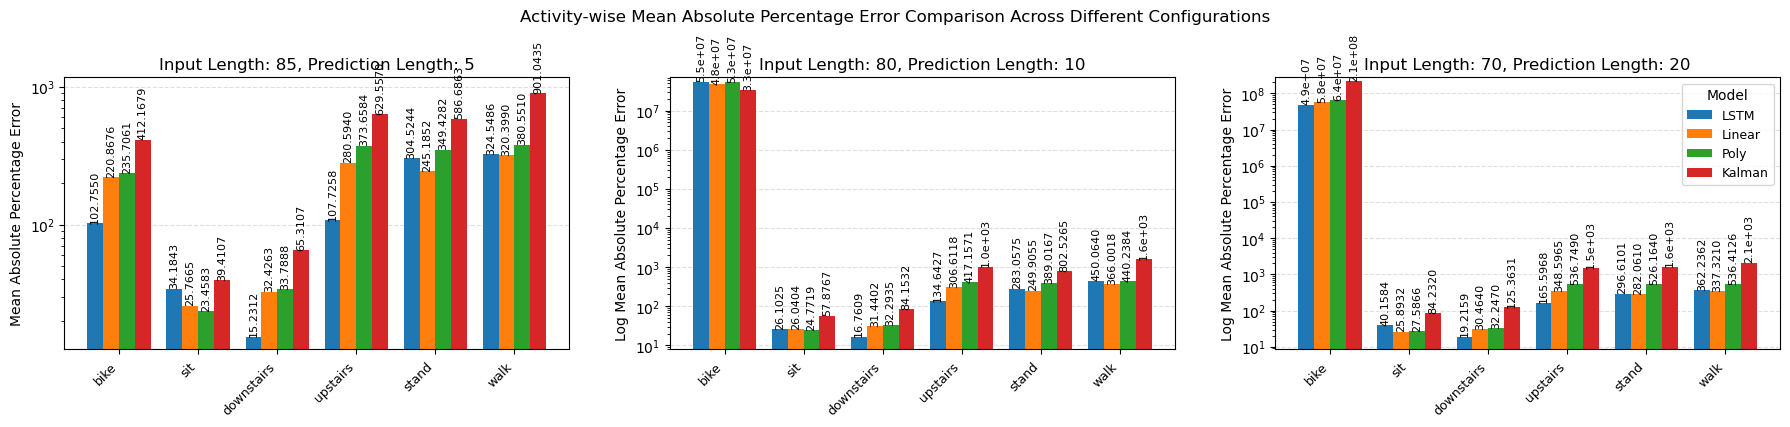


=== Processing metric: mse ===


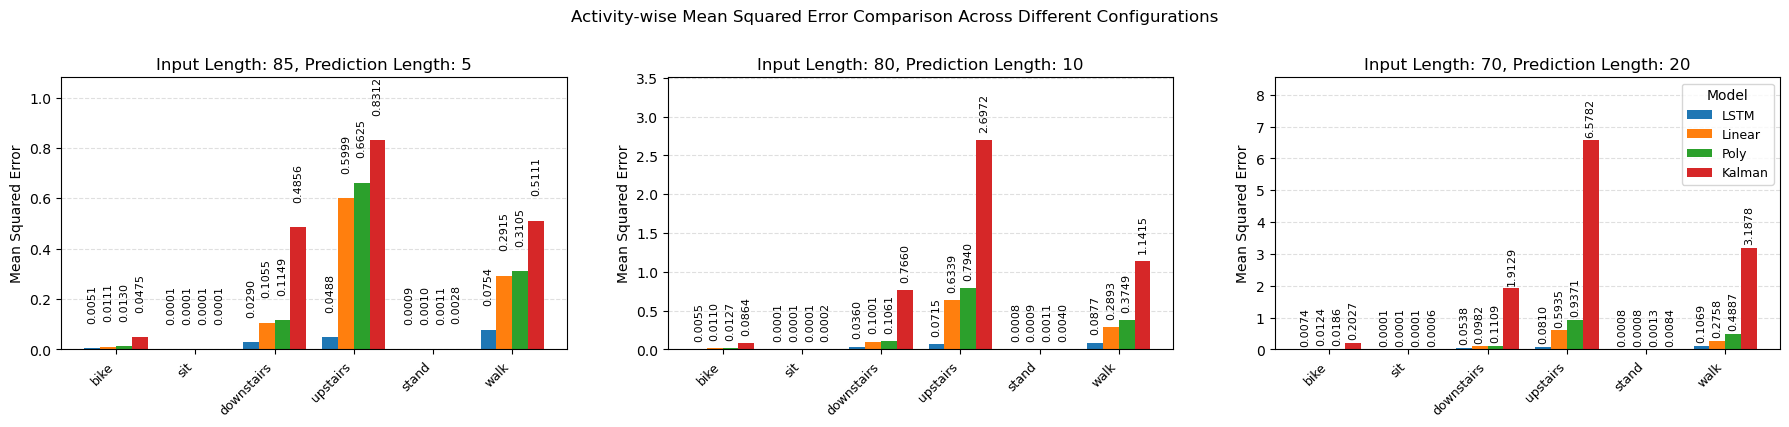


=== Processing metric: pearson ===


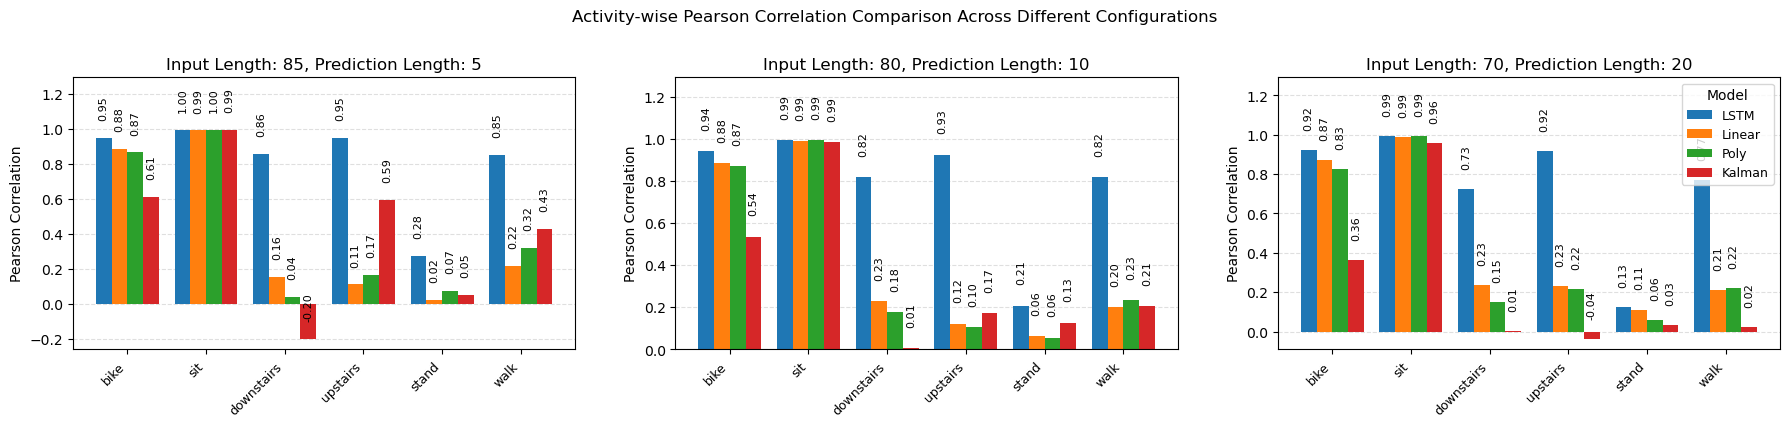

In [9]:
metrics = {'mse', 'mape', 'pearson'}

METRIC_NAME_MAP = {
    'mse': 'Mean Squared Error',
    'mape': 'Mean Absolute Percentage Error',
    'pearson': 'Pearson Correlation',
    'overall_mse': 'Overall MSE',
    'overall_mape': 'Overall MAPE',
    'overall_pearson': 'Overall Pearson'
}

def plot(metrics, all_activity_results):

    all_activities = set()
    for model_key, activity_dict in all_activity_results.items():
        all_activities.update(activity_dict.keys())
    activities = sorted(all_activities)
    activity_labels = [ACTIVITY_NAMES.get(act, f"Unknown-{act}") for act in activities]

    models = list(OrderedDict.fromkeys(k.split("_")[0] for k in all_activity_results.keys()))

    for metric in metrics:
        print(f"\n=== Processing metric: {metric} ===")
        fig, axs = plt.subplots(1, 3, figsize=(18, 4), sharey=False)
        fig.suptitle(f"Activity-wise {METRIC_NAME_MAP.get(metric, metric)} Comparison Across Different Configurations", fontsize=12, y=1.05)

        if len(INPUT_OUTPUT_PAIRS) == 1:
            axs = [axs]

        x = np.arange(len(activities))
        width = 0.8 / len(models)

        for ax, (input_len, pred_len) in zip(axs, INPUT_OUTPUT_PAIRS):
            all_values = []
            if metric == 'mape':
                ax.set_yscale('log')
                ax.set_ylabel(f"Log {METRIC_NAME_MAP.get(metric, metric)}")
            else:
                ax.set_ylabel(METRIC_NAME_MAP.get(metric, metric))

            for i, model in enumerate(models):
                model_key = f"{model}_{input_len}_{pred_len}"
                model_results = all_activity_results.get(model_key, {})

                values = []
                for act in activities:
                    val = model_results.get(act, {}).get(metric, np.nan)
                    if isinstance(val, (list, np.ndarray)):
                        val = val[act]
                    values.append(val)
                all_values.extend([v for v in values if not np.isnan(v)])
                offset = i * width - (width * (len(models)-1) / 2)
                bar_positions = x + offset
                bars = ax.bar(bar_positions, values, width, label=model)

                for bar, value in zip(bars, values):
                    if not np.isnan(value):
                        height = bar.get_height()
                        if metric == 'pearson':
                            label = f"{value:.2f}"
                        elif value > 1000:
                            label = f"{value:.1e}"
                        else:
                            label = f"{value:.4f}"
                        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1,
                                label, ha='center', va='bottom', fontsize=8, rotation=90)

            ax.set_title(f"Input Length: {input_len}, Prediction Length: {pred_len}")
            ax.set_xticks(x)
            ax.set_xticklabels(activity_labels, rotation=45, ha='right', fontsize=9)
            ax.tick_params(axis='x', pad=4)
            ax.yaxis.grid(True, linestyle='--', alpha=0.4)
            ax.set_axisbelow(True)

                # Add a small margin to the top of the plot
            if all_values:
                max_val = max(all_values)
                ax.set_ylim(top=max_val * 1.3)     

        axs[0].set_ylabel(METRIC_NAME_MAP.get(metric, metric))
        axs[-1].legend(title="Model", fontsize=9)
        plt.tight_layout(rect=[0, 0.04, 1, 0.96])
        plt.subplots_adjust(wspace=0.2, bottom=0.2, top=0.88)
        plt.savefig(f"baseline_plots/activity_{metric}_comparison")
        plt.show()


plot(metrics, all_activity_results)

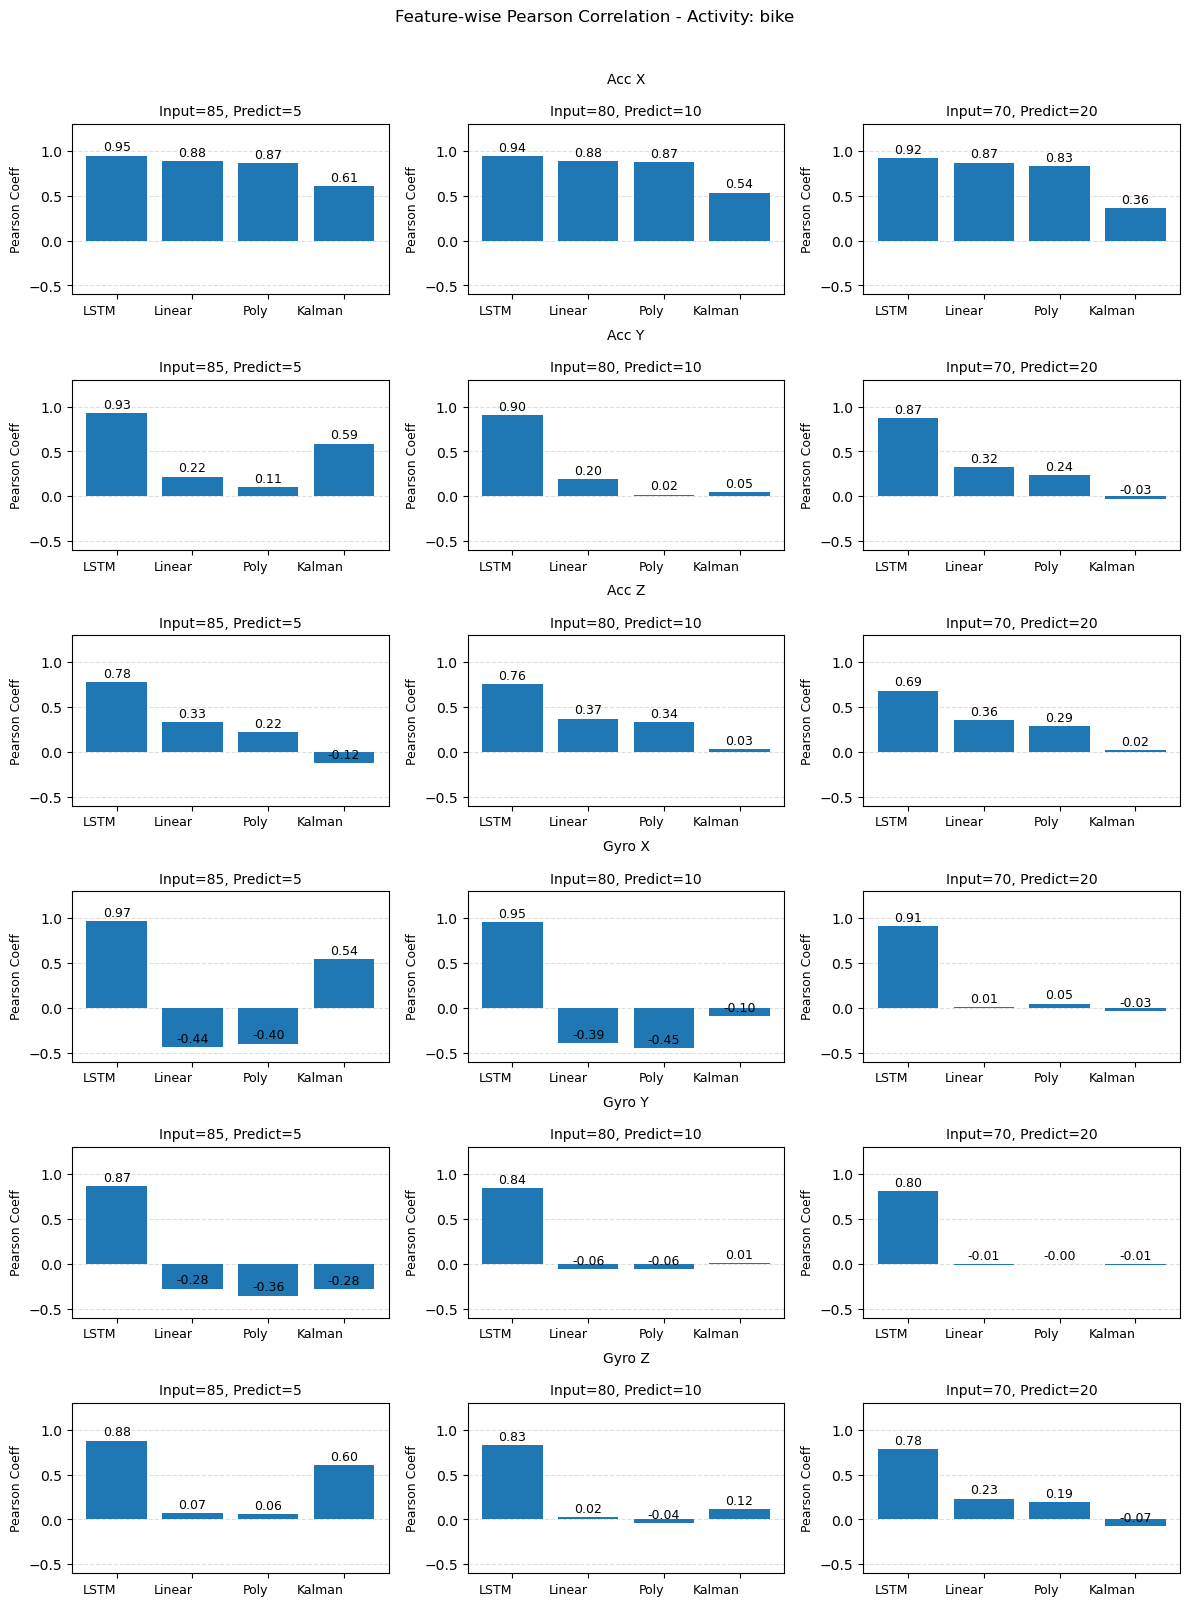

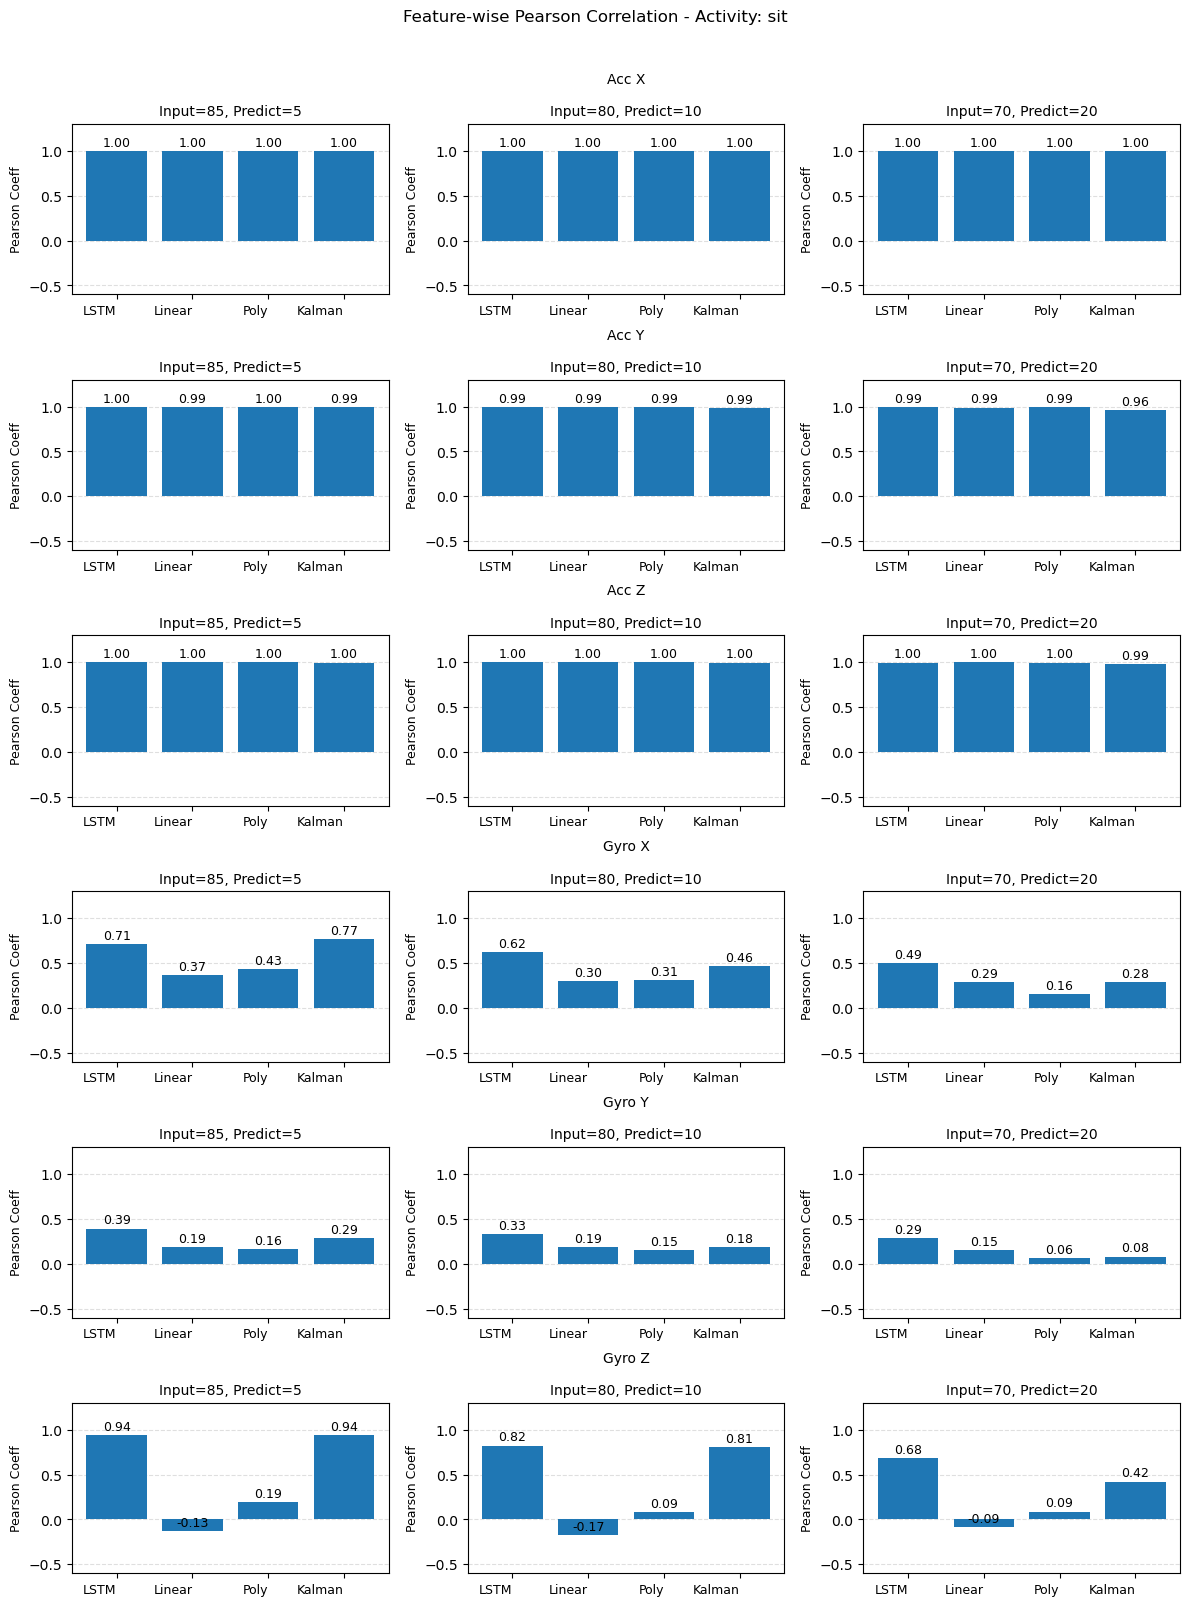

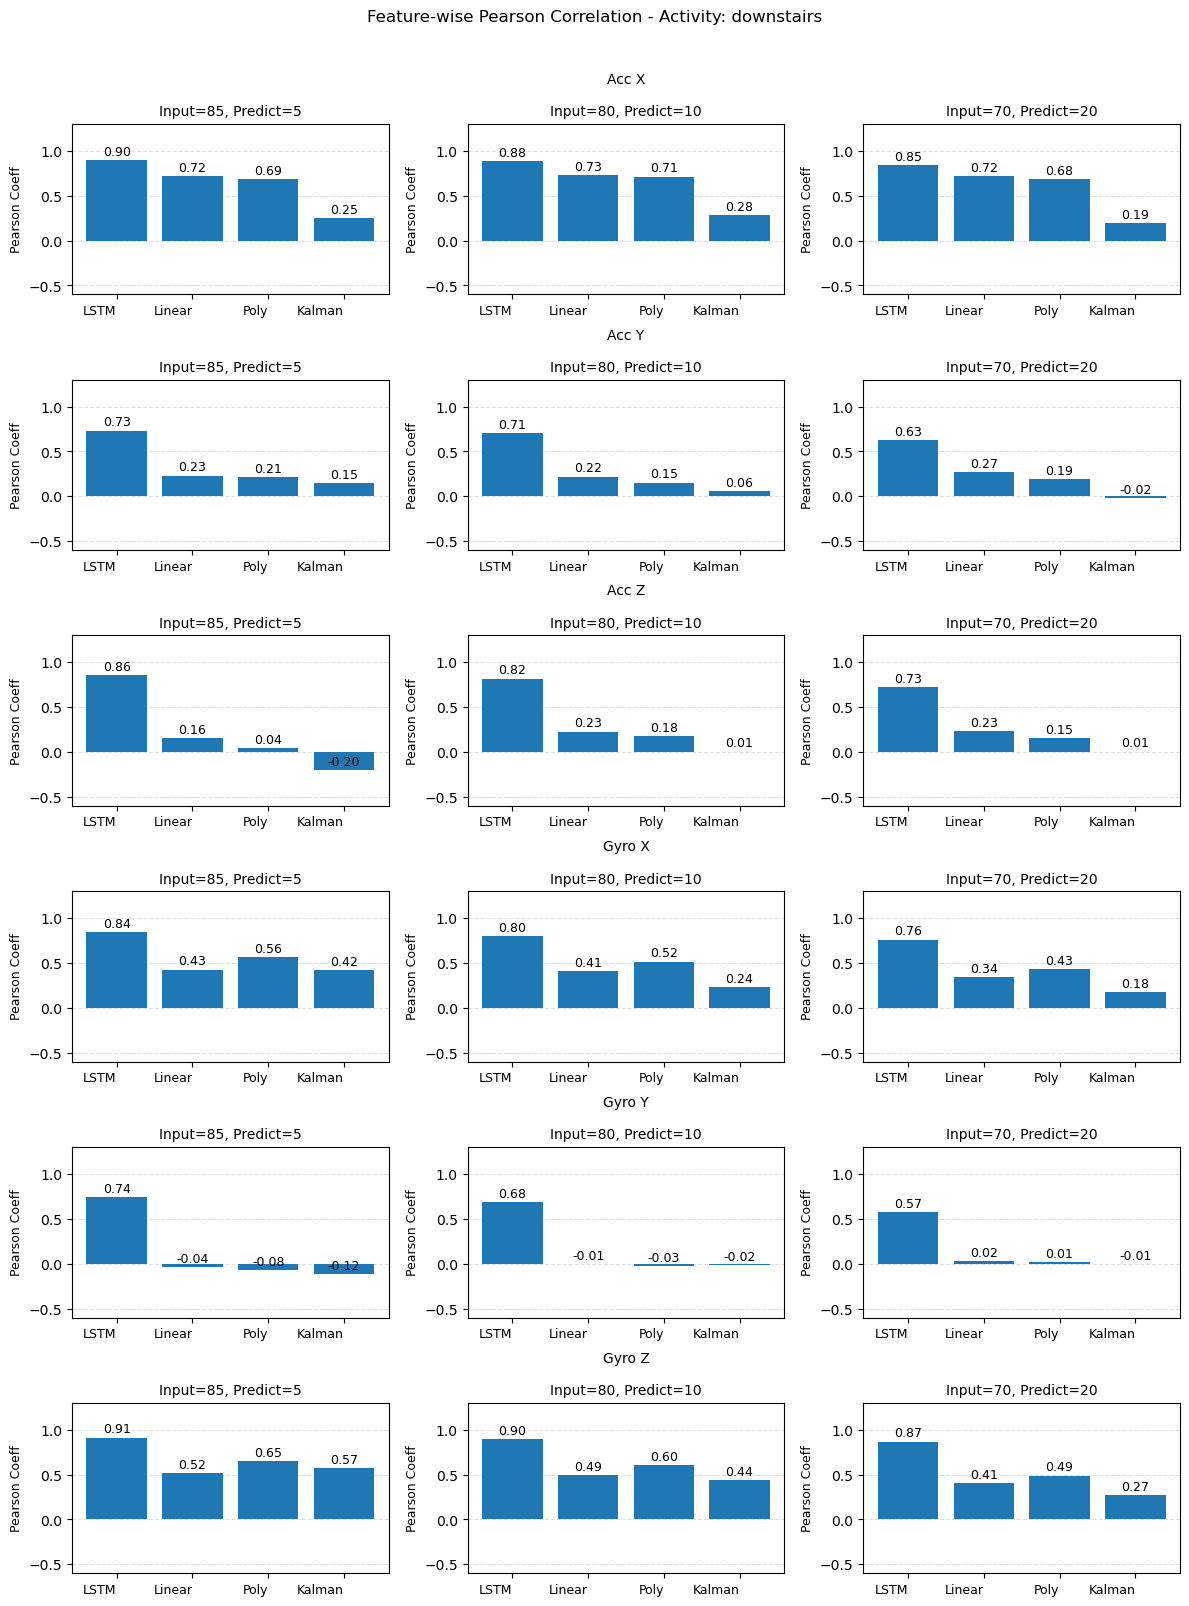

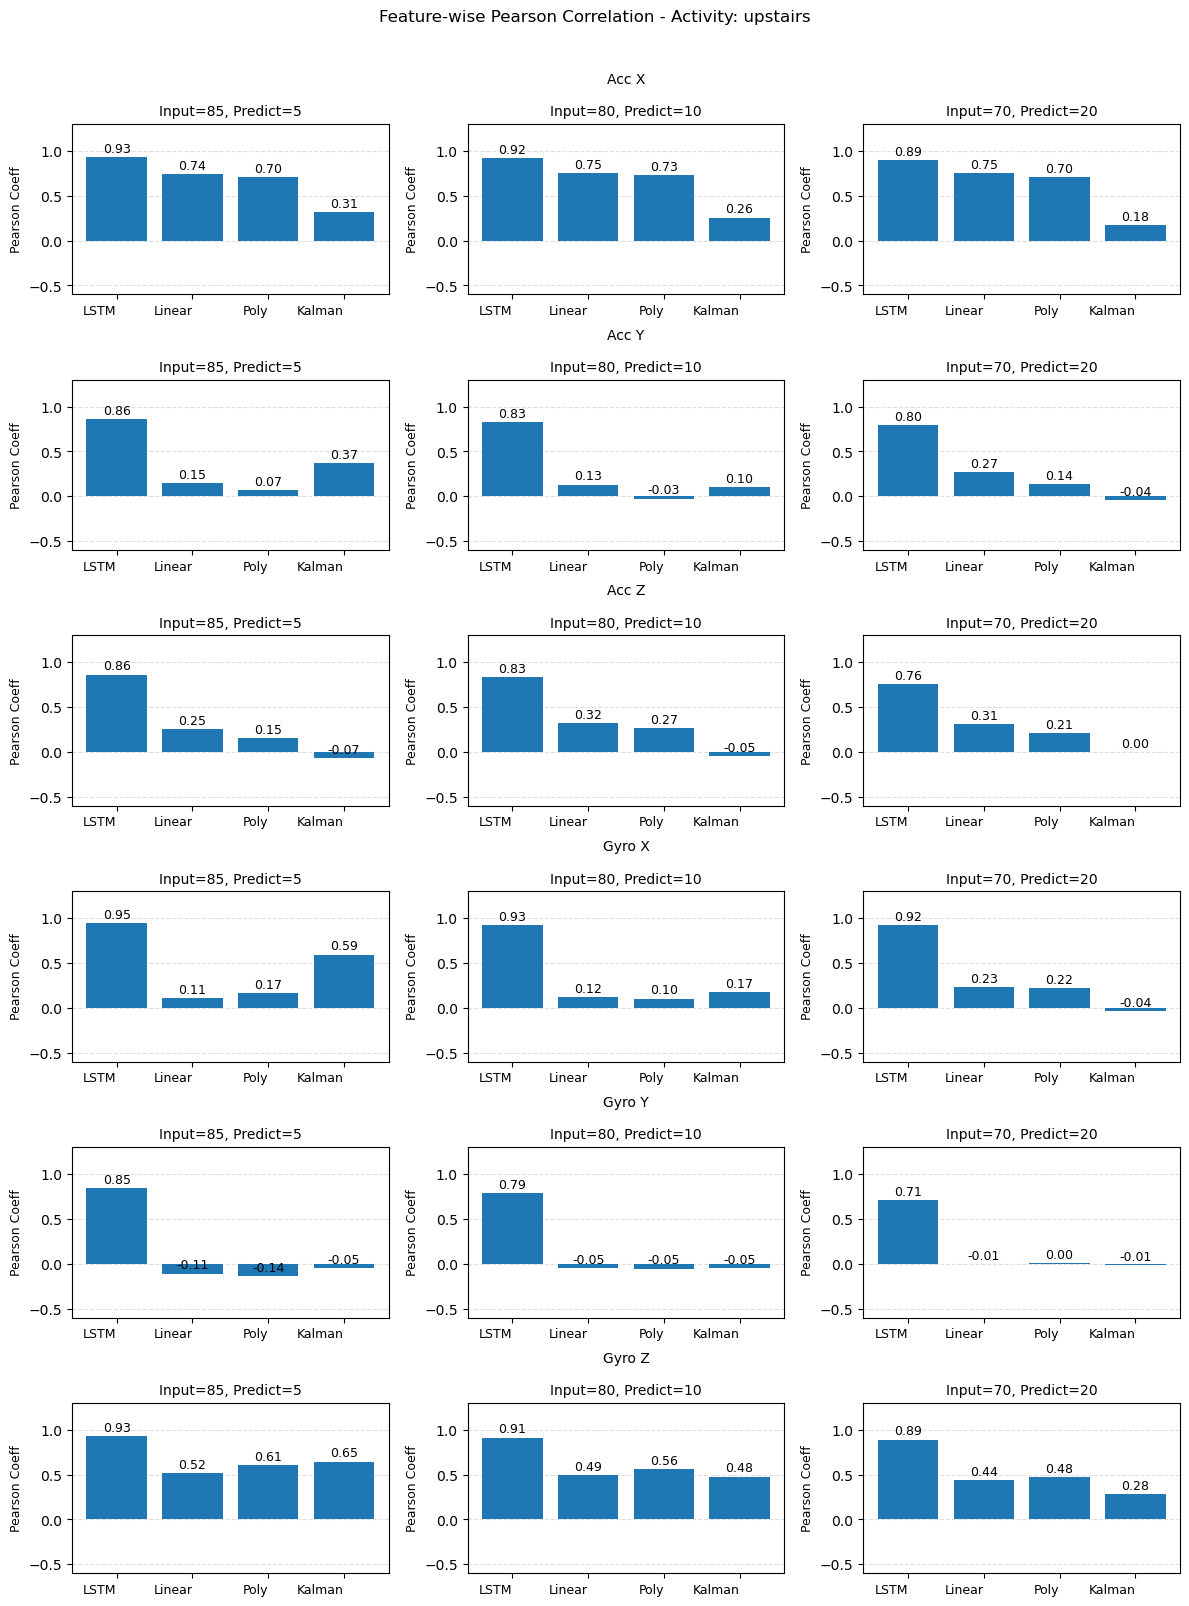

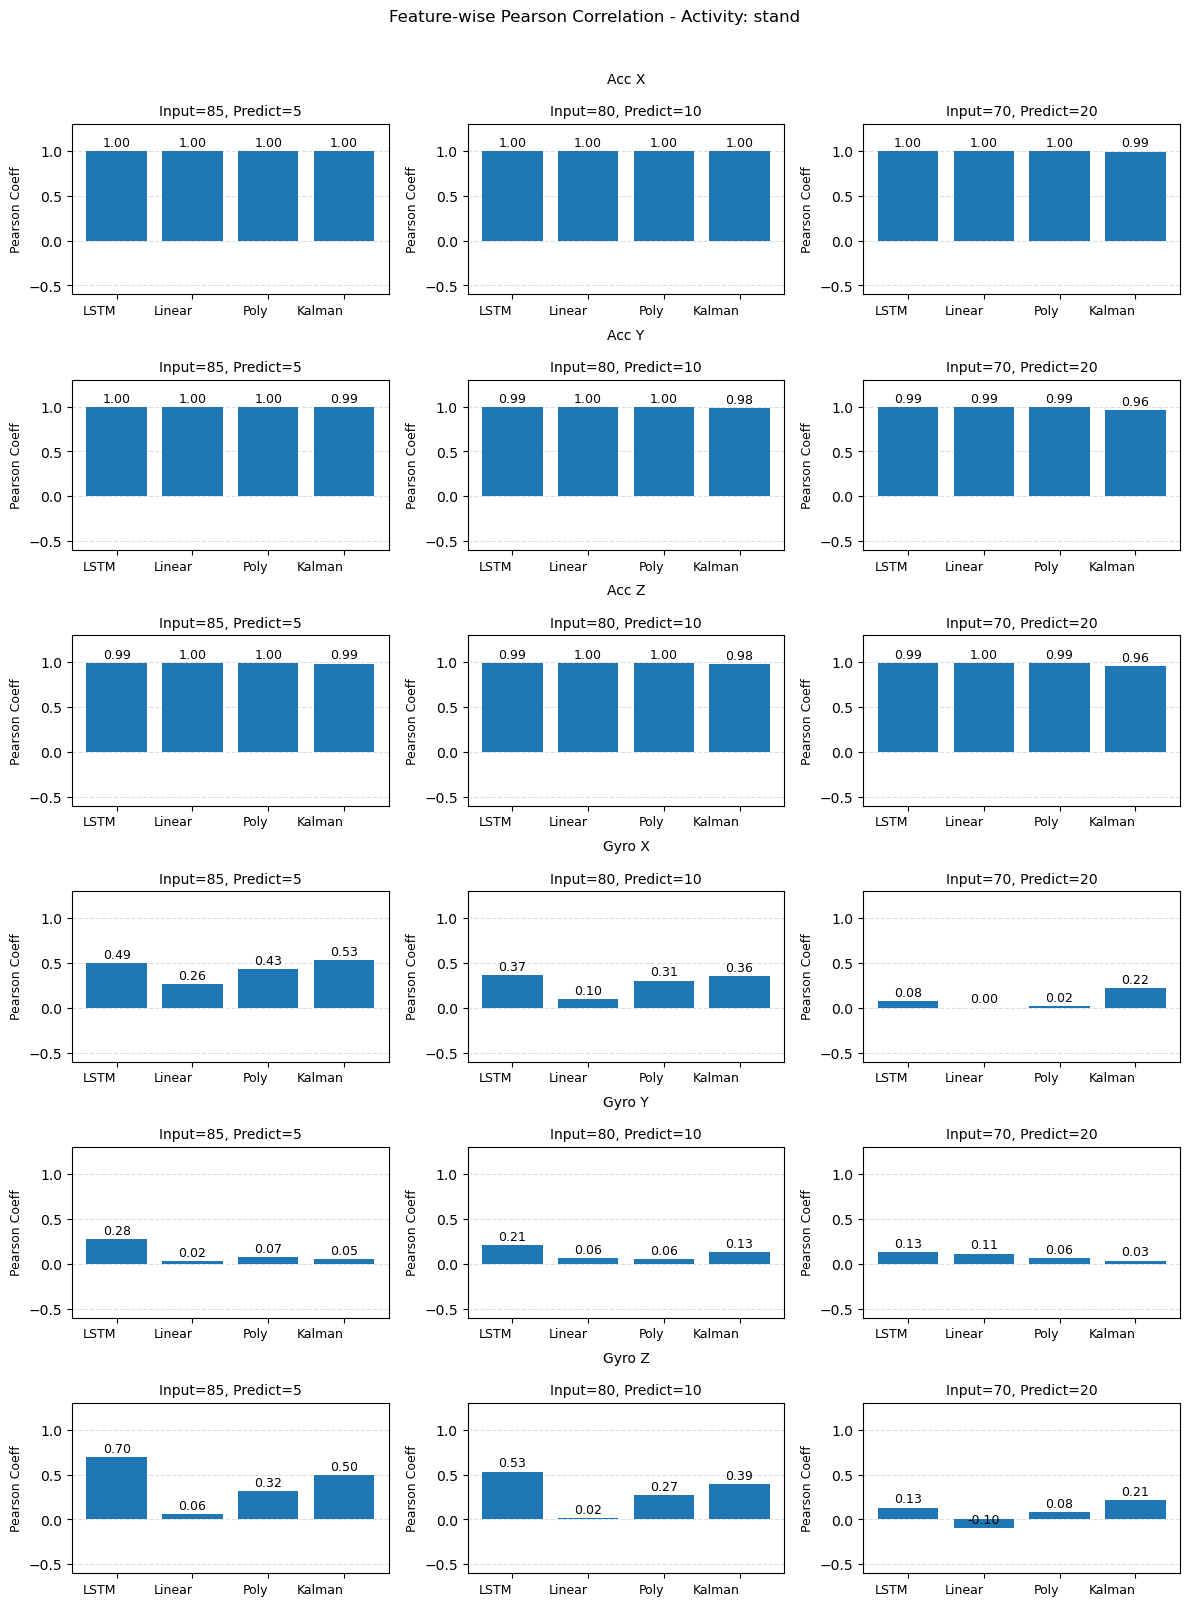

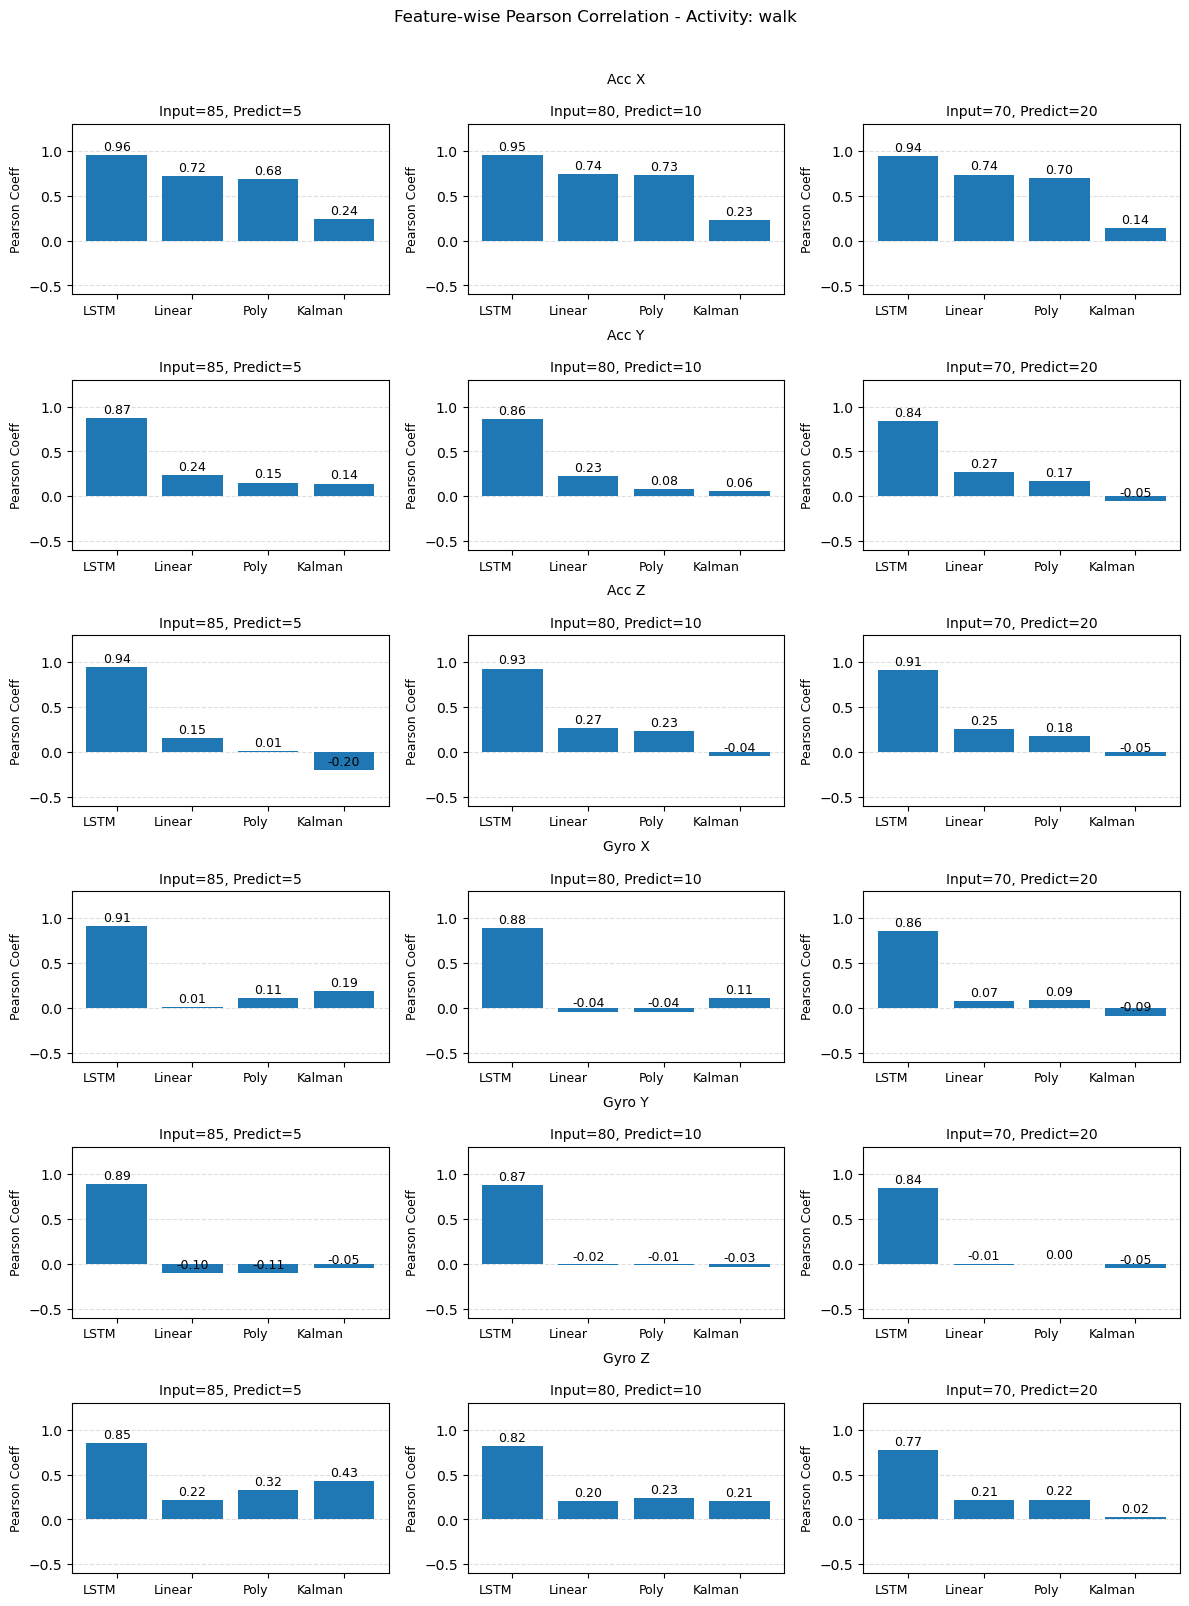

In [10]:
def visualize_feature_correlations_per_activity(activity_results, input_output_pairs, activity_names):
    
    feature_names = ['Acc X', 'Acc Y', 'Acc Z', 'Gyro X', 'Gyro Y', 'Gyro Z']
    models = list(OrderedDict.fromkeys(k.split("_")[0] for k in all_activity_results.keys()))

    # Find all activities present
    activities = sorted({act for cfg in activity_results.values() for act in cfg})
    
    for activity in activities:
        label = activity_names.get(activity, f"Activity {activity}")
        fig, axs = plt.subplots(6, len(input_output_pairs),
                                 figsize=(4 * len(input_output_pairs), 16),sharey=False)
        fig.suptitle(f'Feature-wise Pearson Correlation - Activity: {label}', fontsize=12, y=1.001)

        for i, feature in enumerate(feature_names):
            for j, (inp, pred) in enumerate(input_output_pairs):
                ax = axs[i, j] if len(input_output_pairs) > 1 else axs[i]
                # collect pearson for each model
                vals = []
                for m in models:
                    key = f"{m}_{inp}_{pred}"
                    vals.append(
                        activity_results
                        .get(key, {})
                        .get(activity, {})
                        .get('pearson', [np.nan]*6)[i]
                    )
                bars = ax.bar(models, vals) 
                ax.set_ylim(-0.6,1.3)
                ax.set_xticks(range(len(models)))
                ax.set_xticklabels(models, rotation=0, ha='right', fontsize=9)
                ax.set_ylabel("Pearson Coeff", fontsize=9)
                
                ax.set_title(f'{feature} Input Length={inp}, Prediction Lenght={pred}', fontsize=9)
                
                # annotate with values 
                for b, v in zip(bars, vals):
                    ax.text(b.get_x() + b.get_width()/2, 
                            v + (0.02), f'{v:.2f}', ha='center', va='bottom', fontsize=9)
                    
                # Add column title
                title = f'Input={inp}, Predict={pred}'
                if j == 1:
                    title = f'\n{feature}\n\n' + title
                ax.set_title(title, fontsize=10)
                ax.yaxis.grid(True, linestyle='--', alpha=0.4)
                ax.set_axisbelow(True)
                    
        plt.tight_layout()
        plt.subplots_adjust(wspace=0.25, hspace=0.5) 
        plt.savefig(f'baseline_plots/feature_pearson_{label}')
        plt.show()


visualize_feature_correlations_per_activity(all_activity_results, INPUT_OUTPUT_PAIRS, ACTIVITY_NAMES)


Plotting bike (ID: 0), sample index: 244
Saved plot for bike to baseline_plots/predictions/bike.png


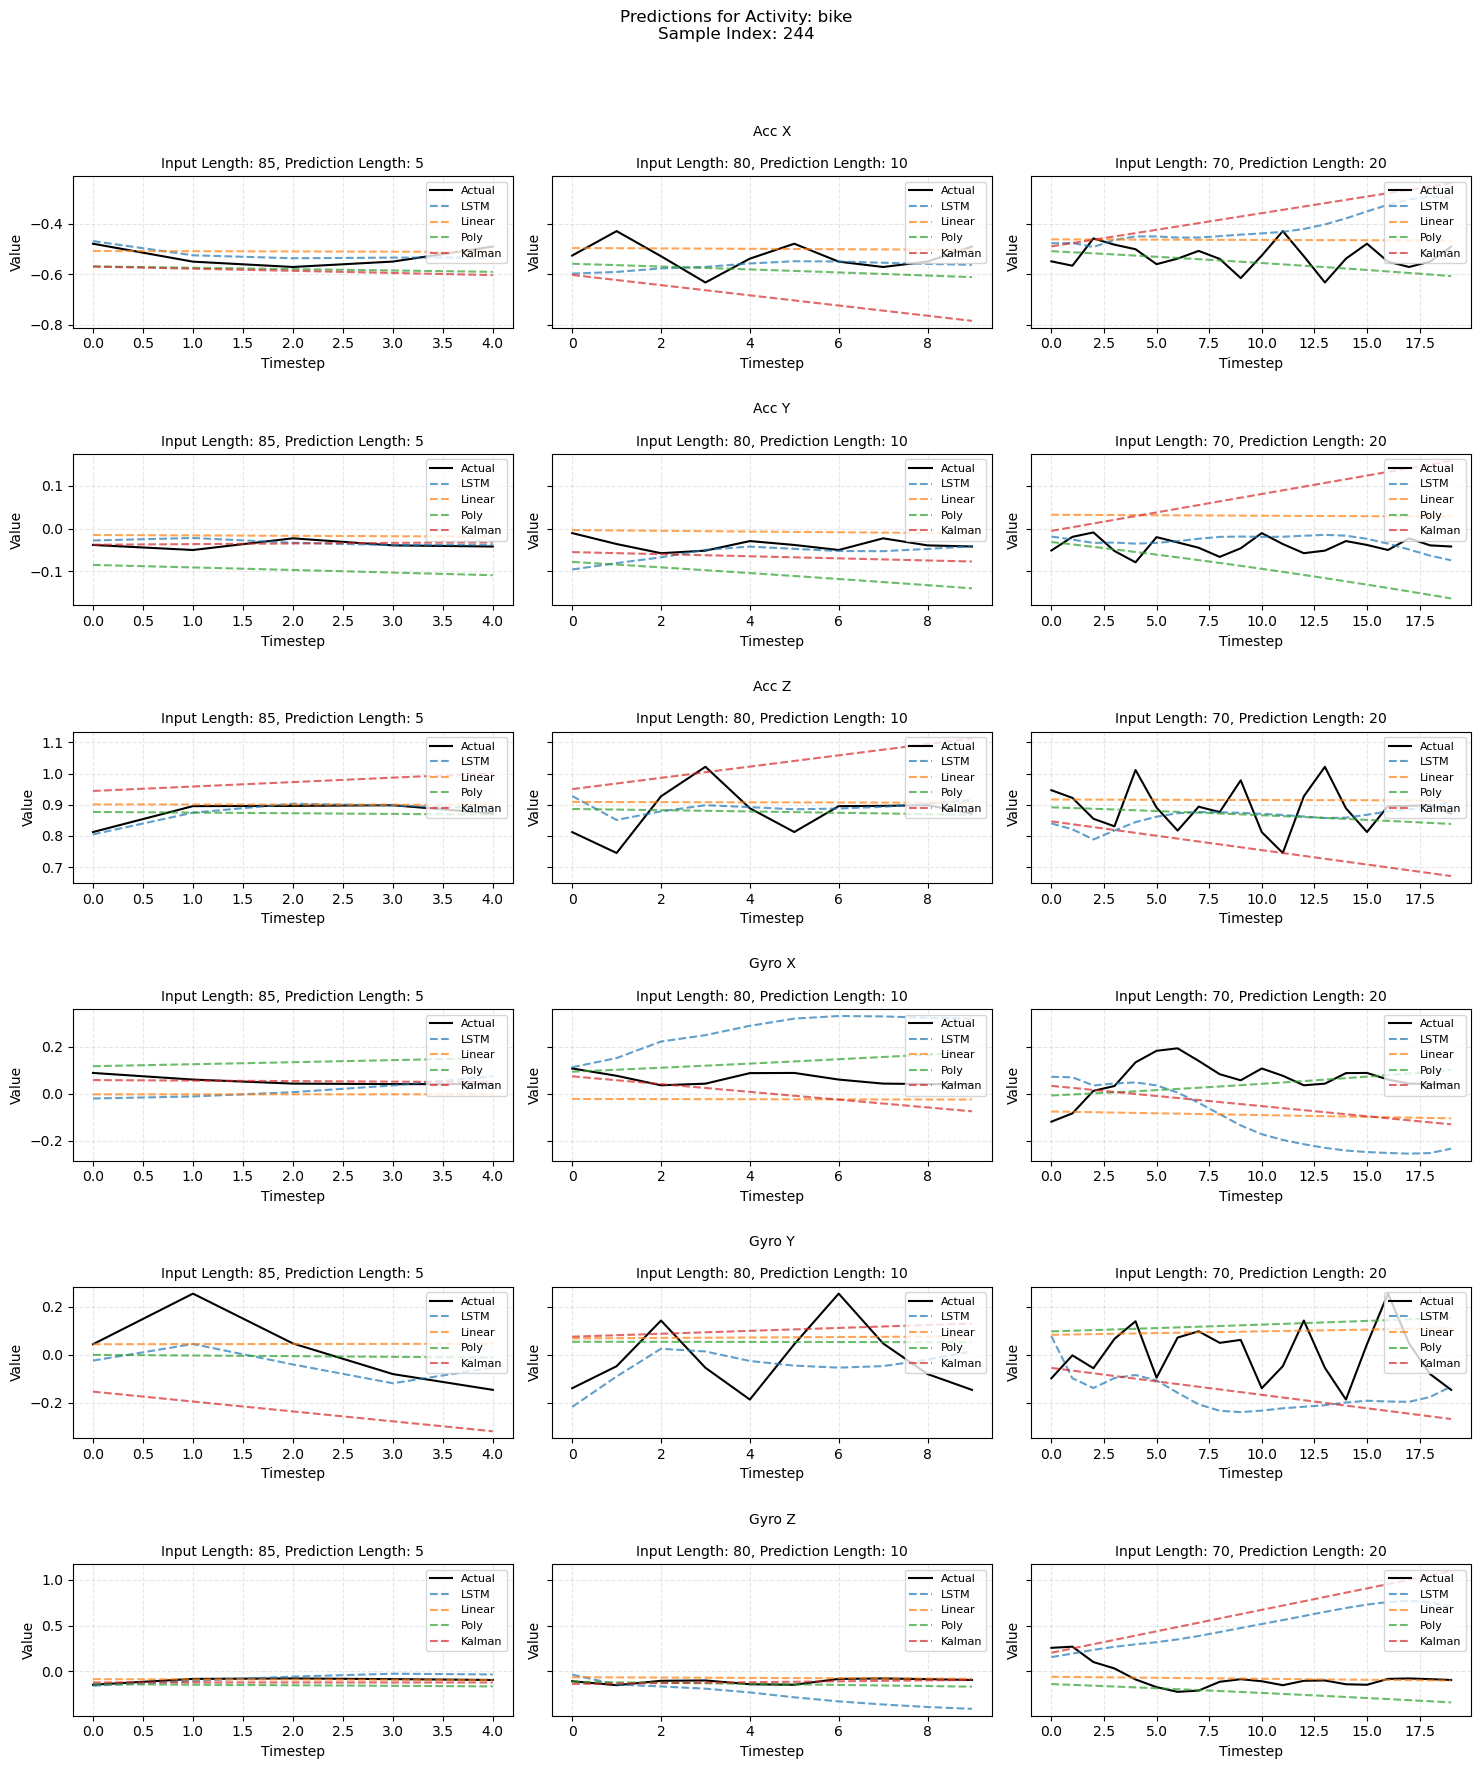

Plotting sit (ID: 1), sample index: 29
Saved plot for sit to baseline_plots/predictions/sit.png


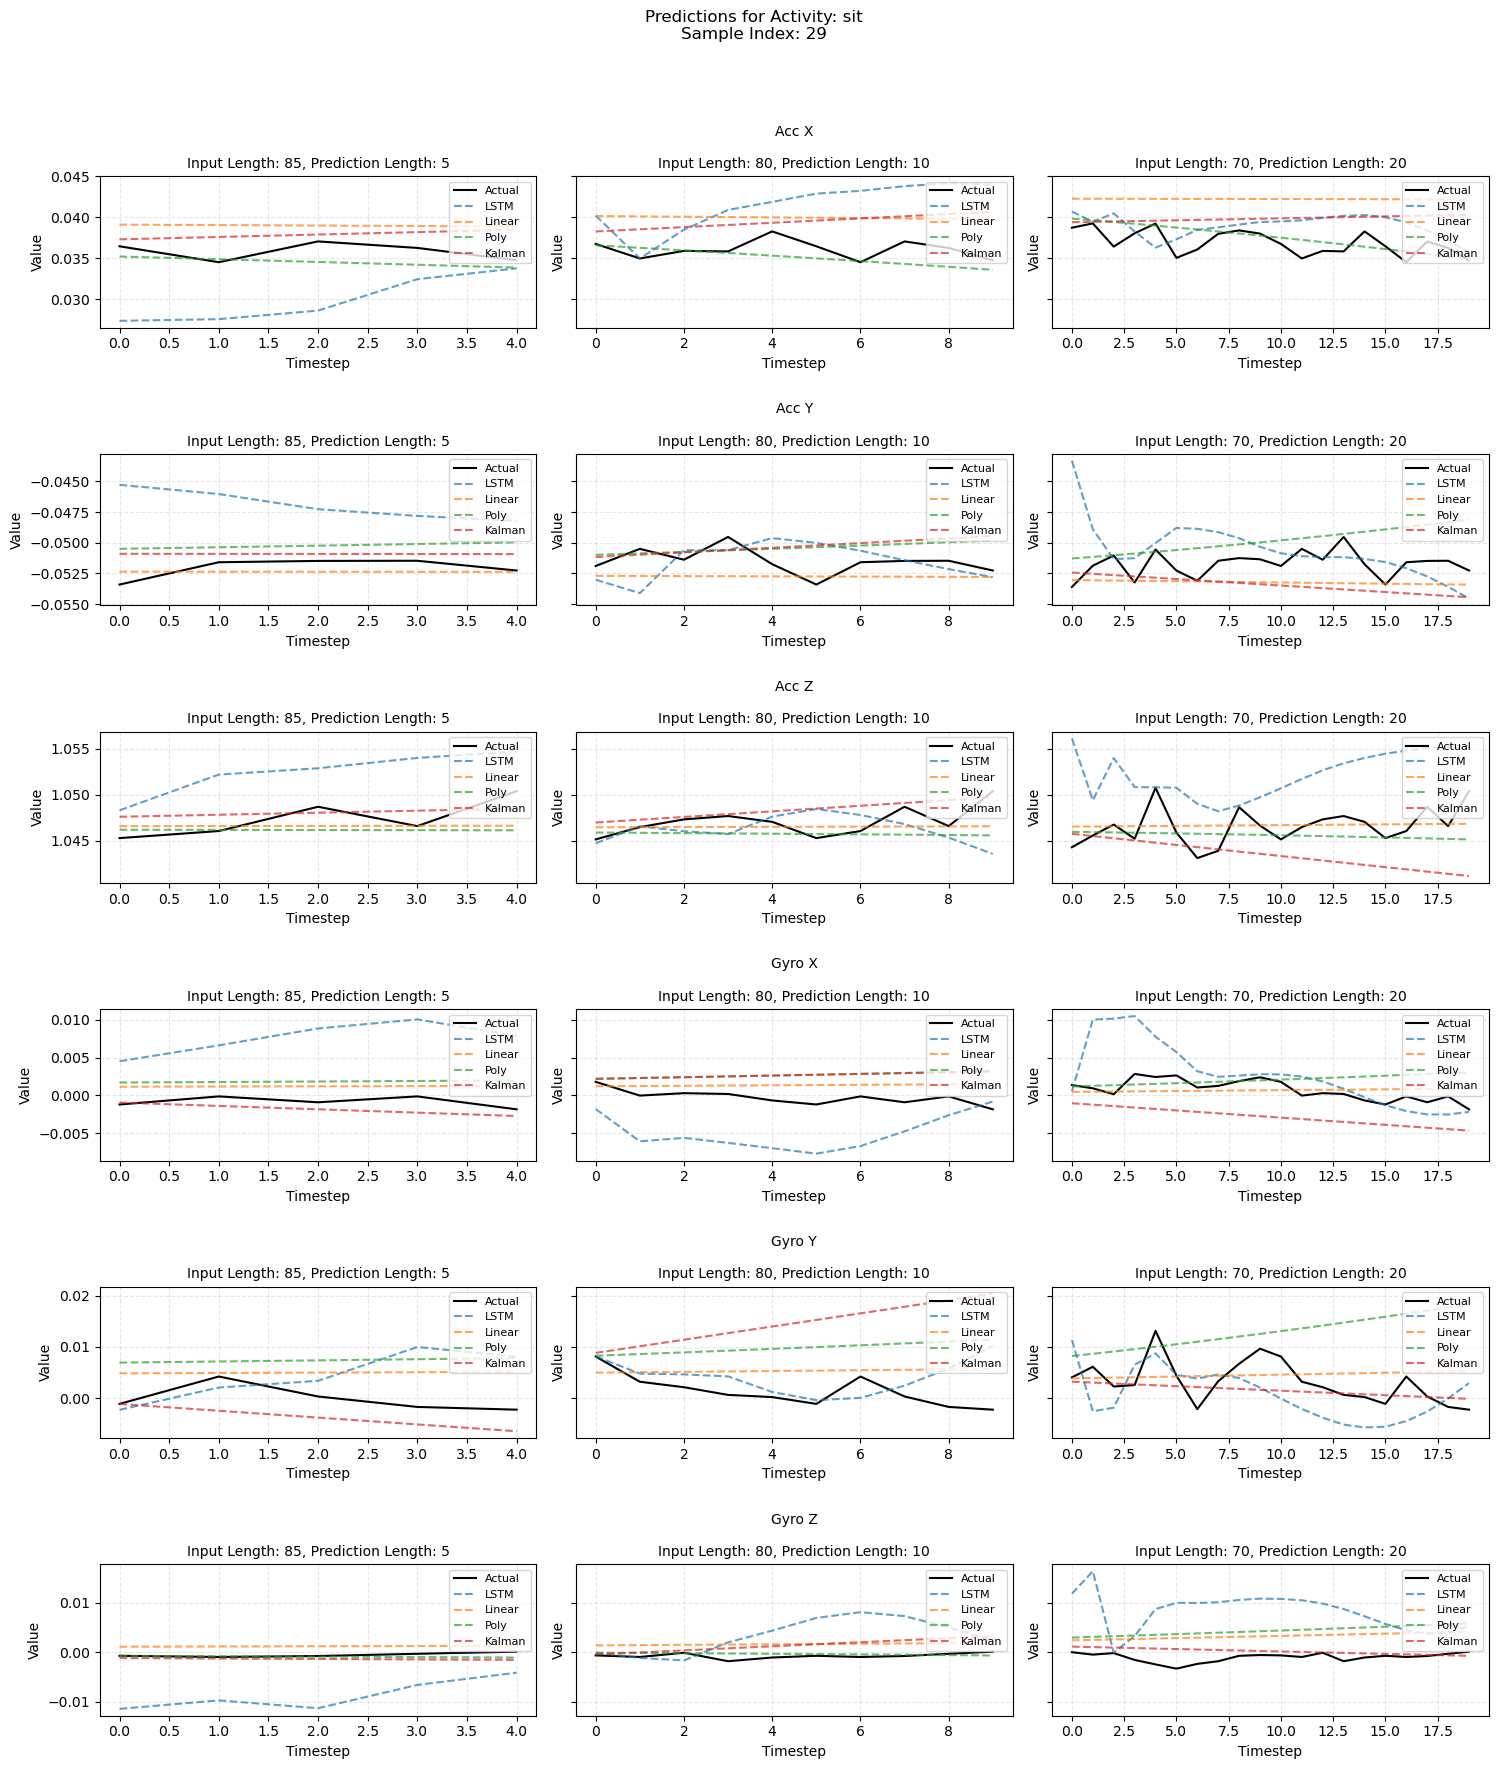

Plotting downstairs (ID: 2), sample index: 189
Saved plot for downstairs to baseline_plots/predictions/downstairs.png


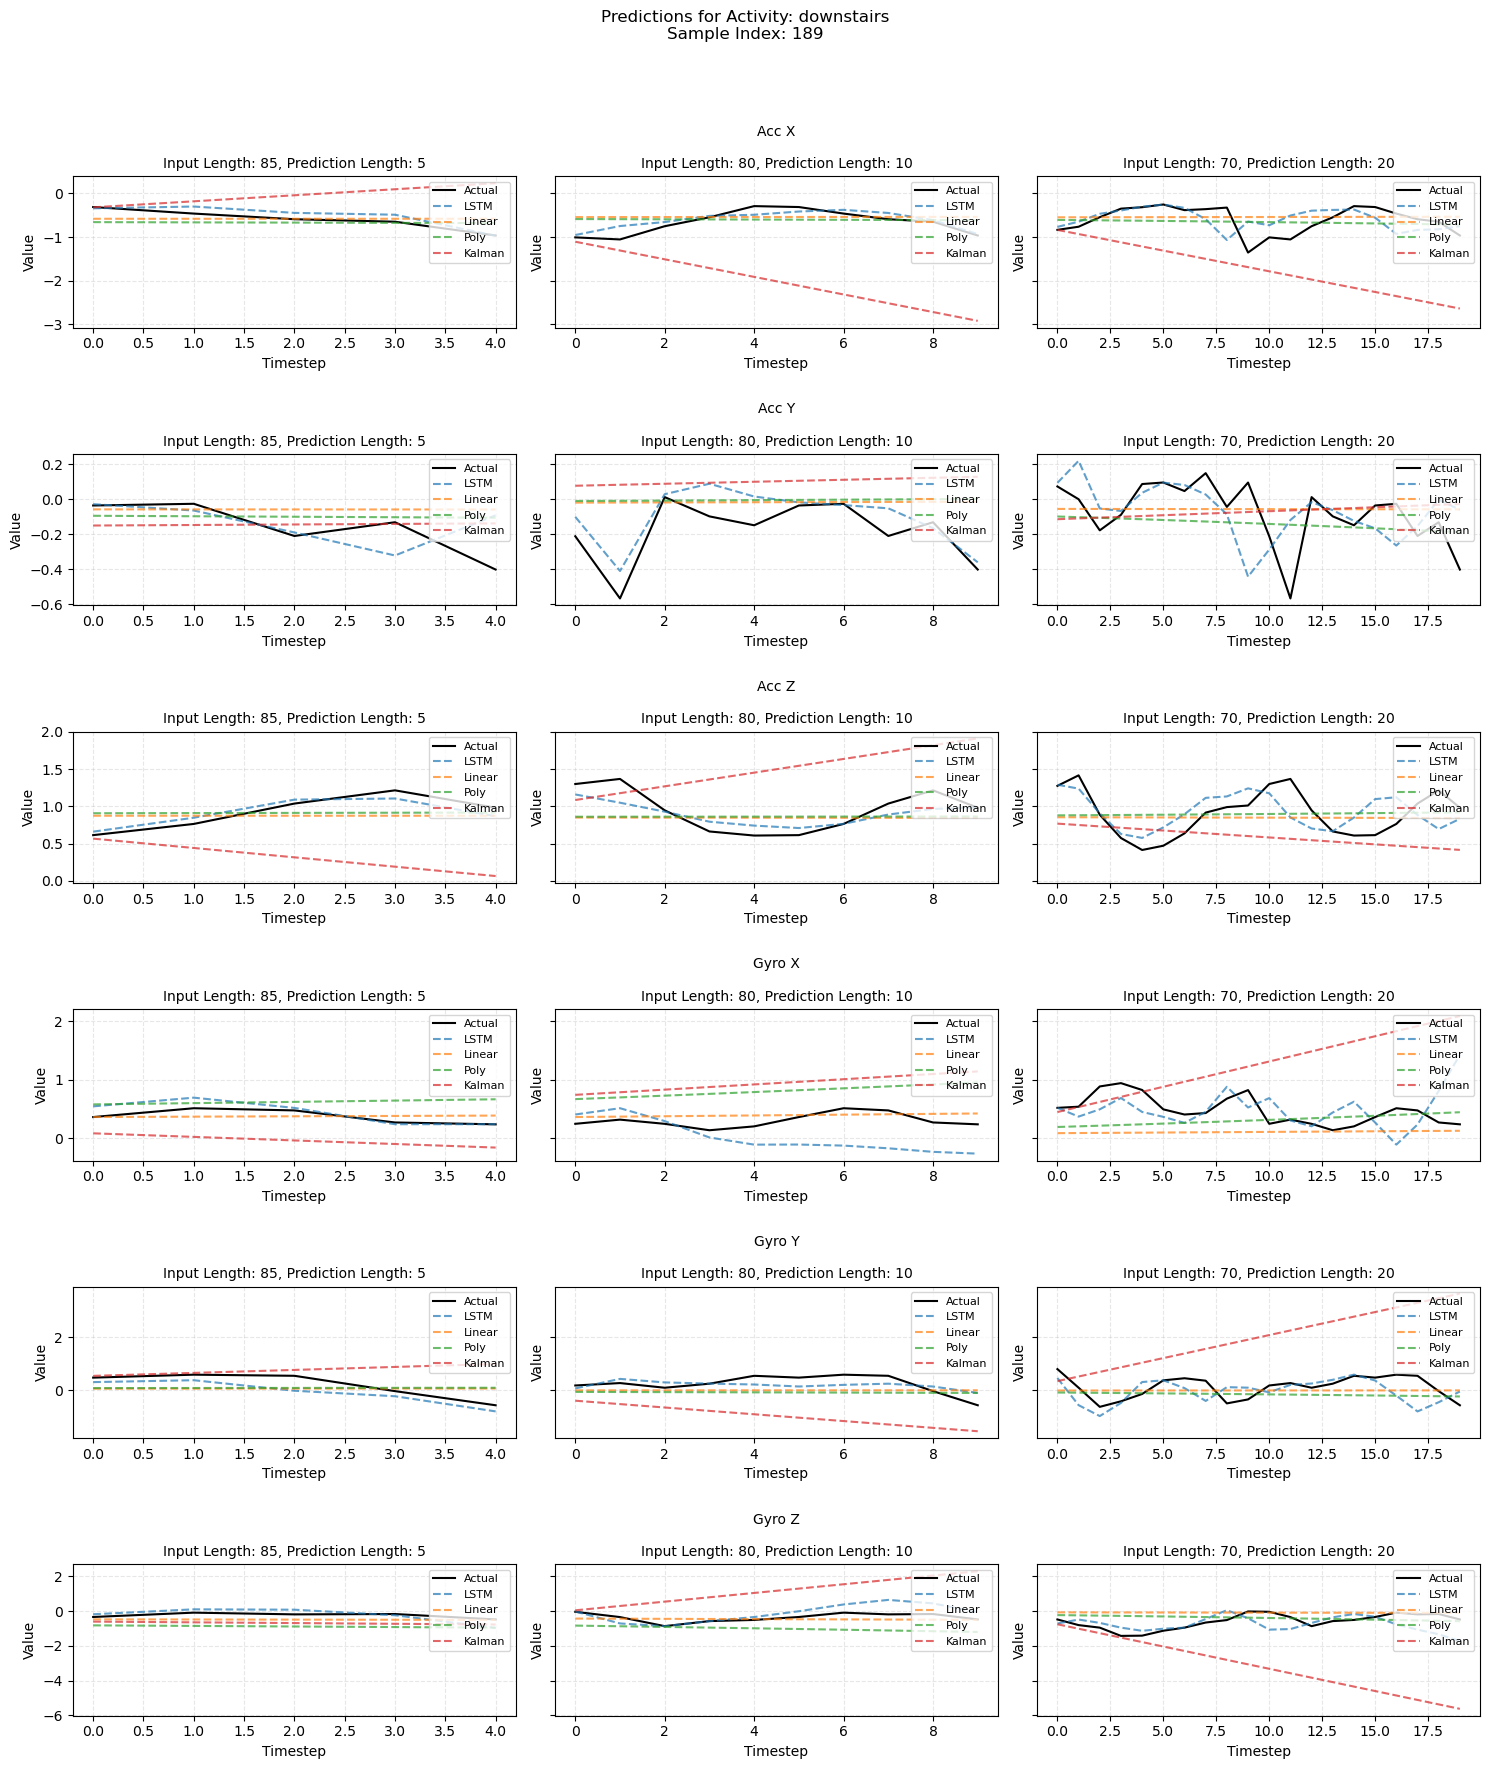

Plotting upstairs (ID: 3), sample index: 211
Saved plot for upstairs to baseline_plots/predictions/upstairs.png


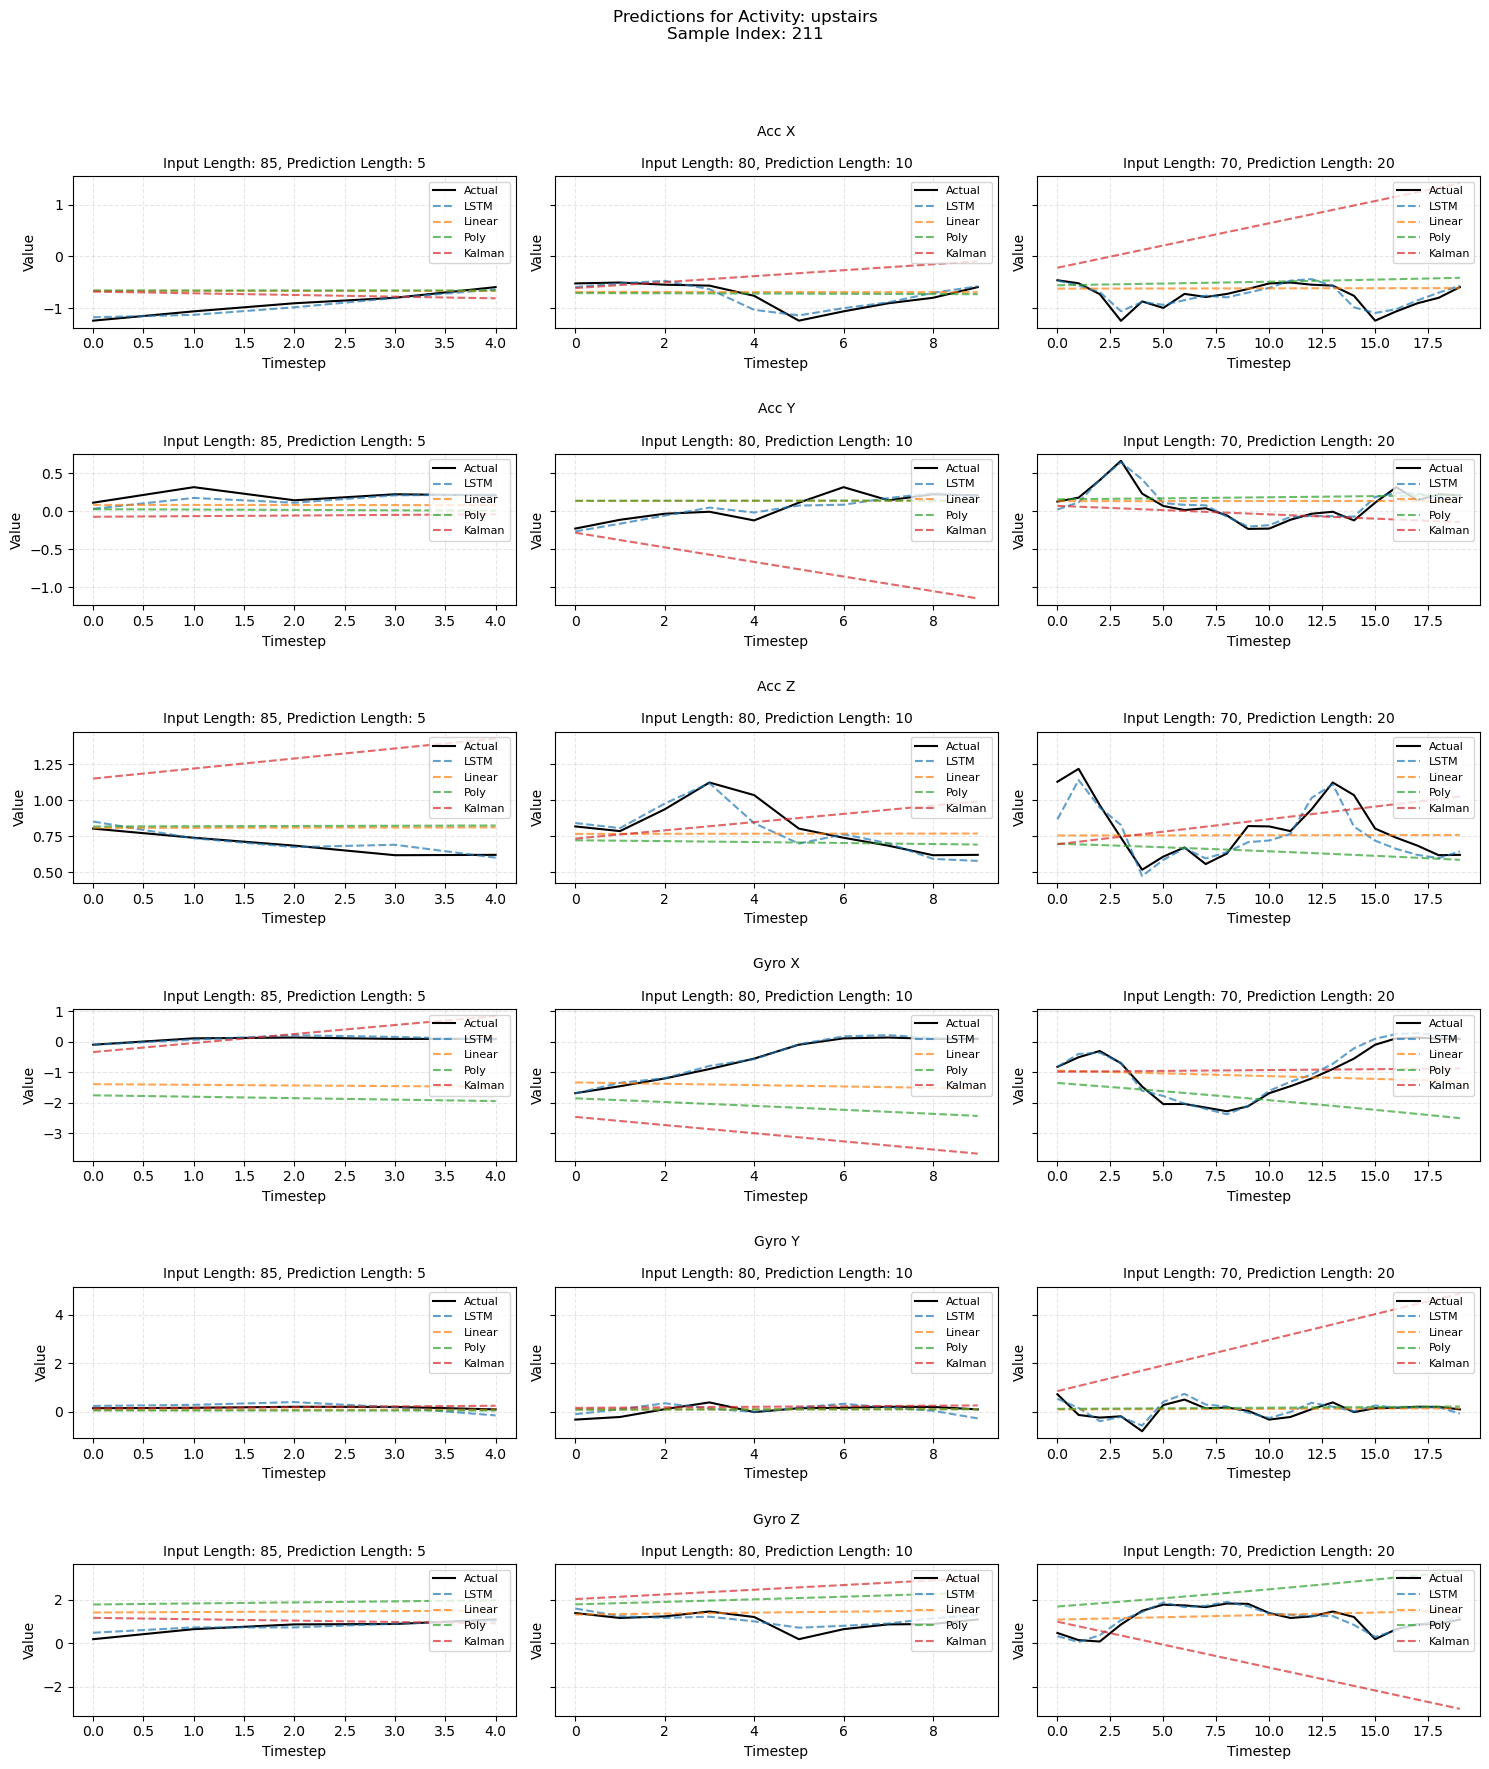

Plotting stand (ID: 4), sample index: 0
Saved plot for stand to baseline_plots/predictions/stand.png


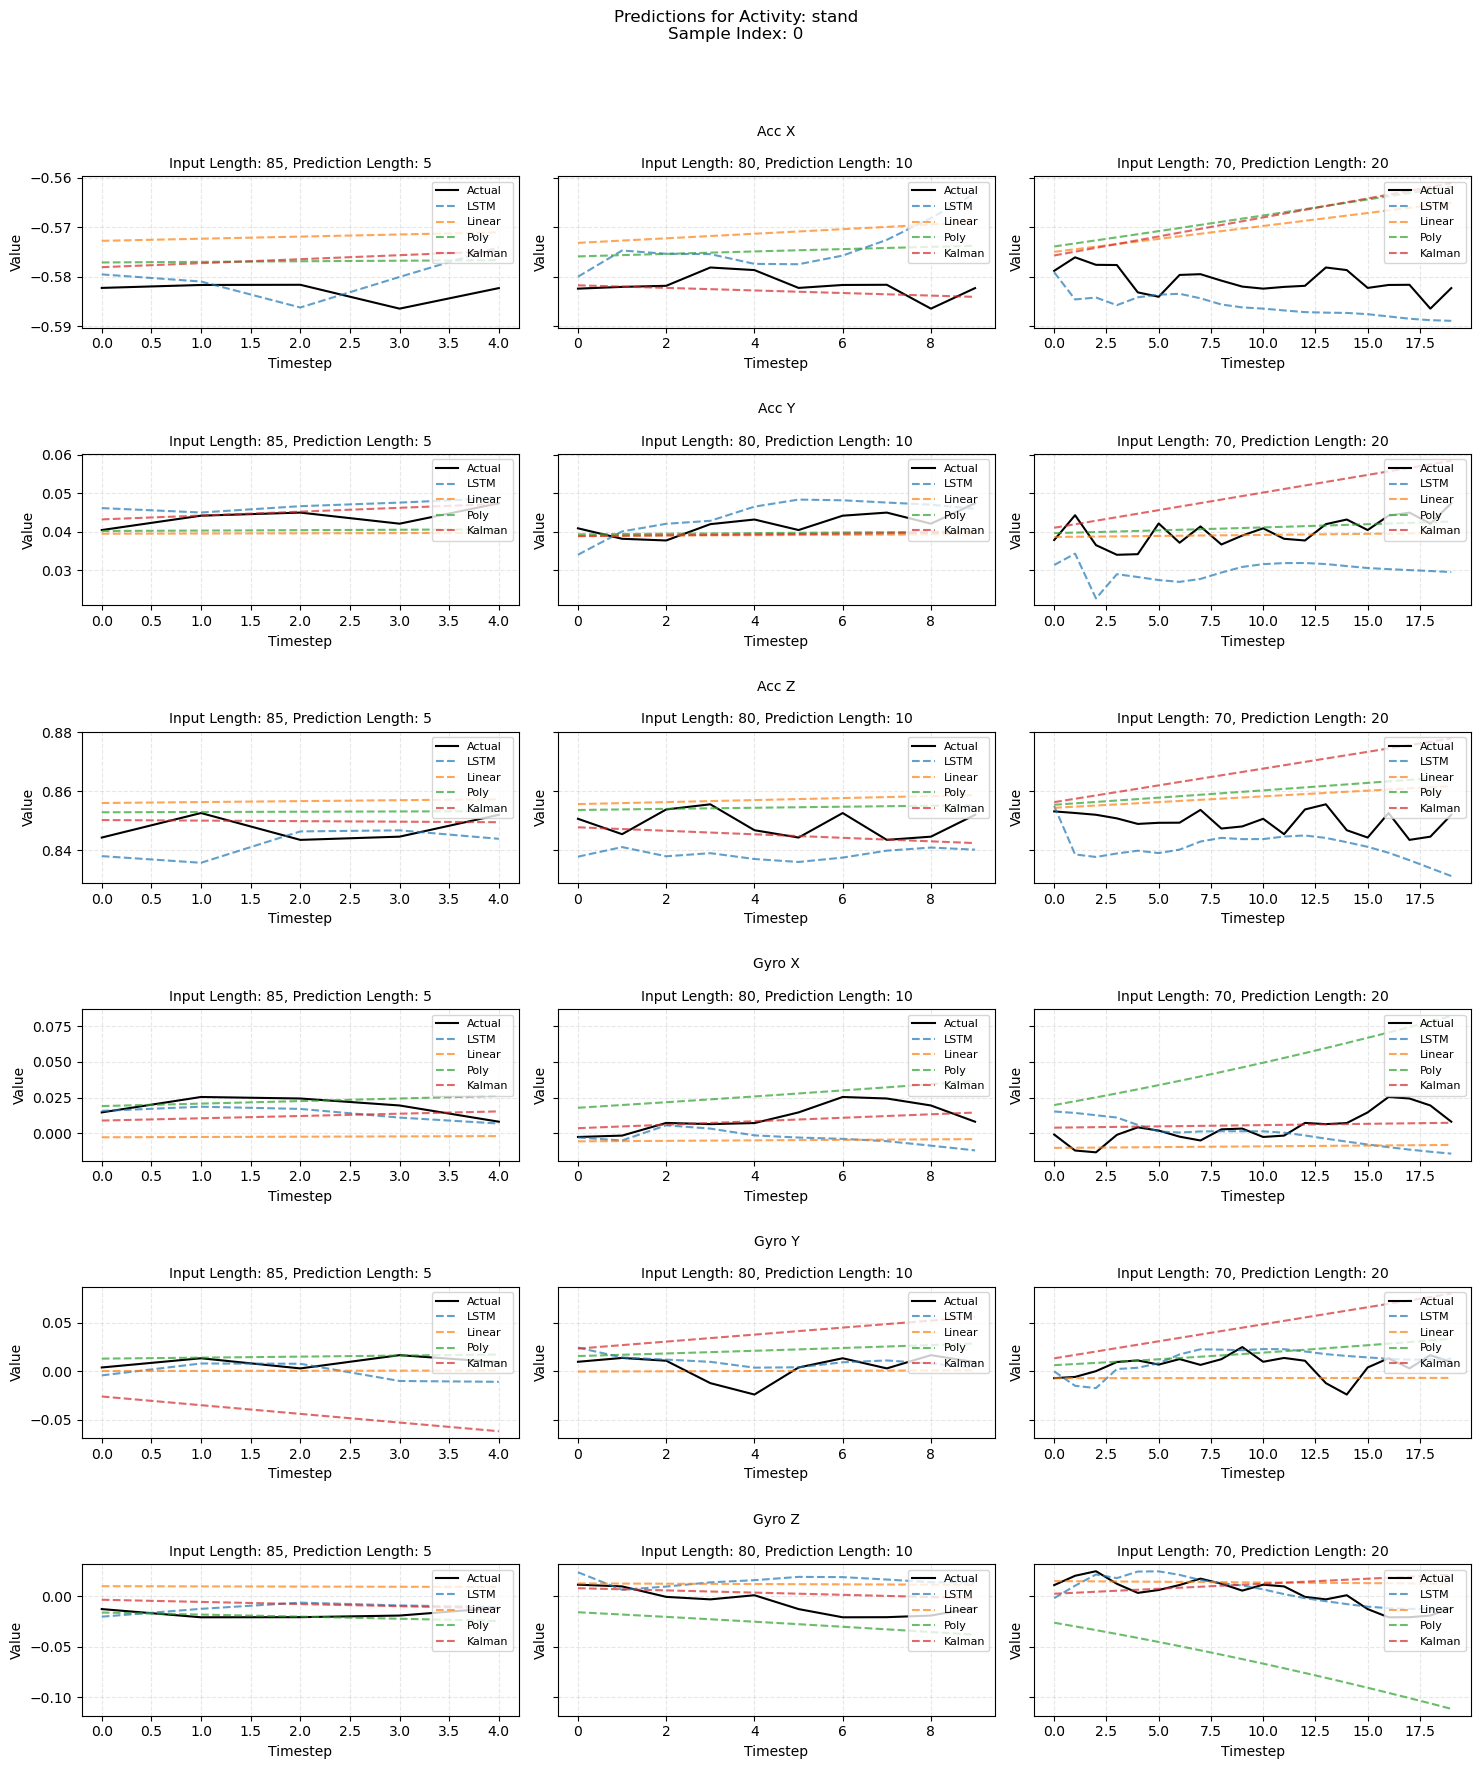

Plotting walk (ID: 5), sample index: 117
Saved plot for walk to baseline_plots/predictions/walk.png


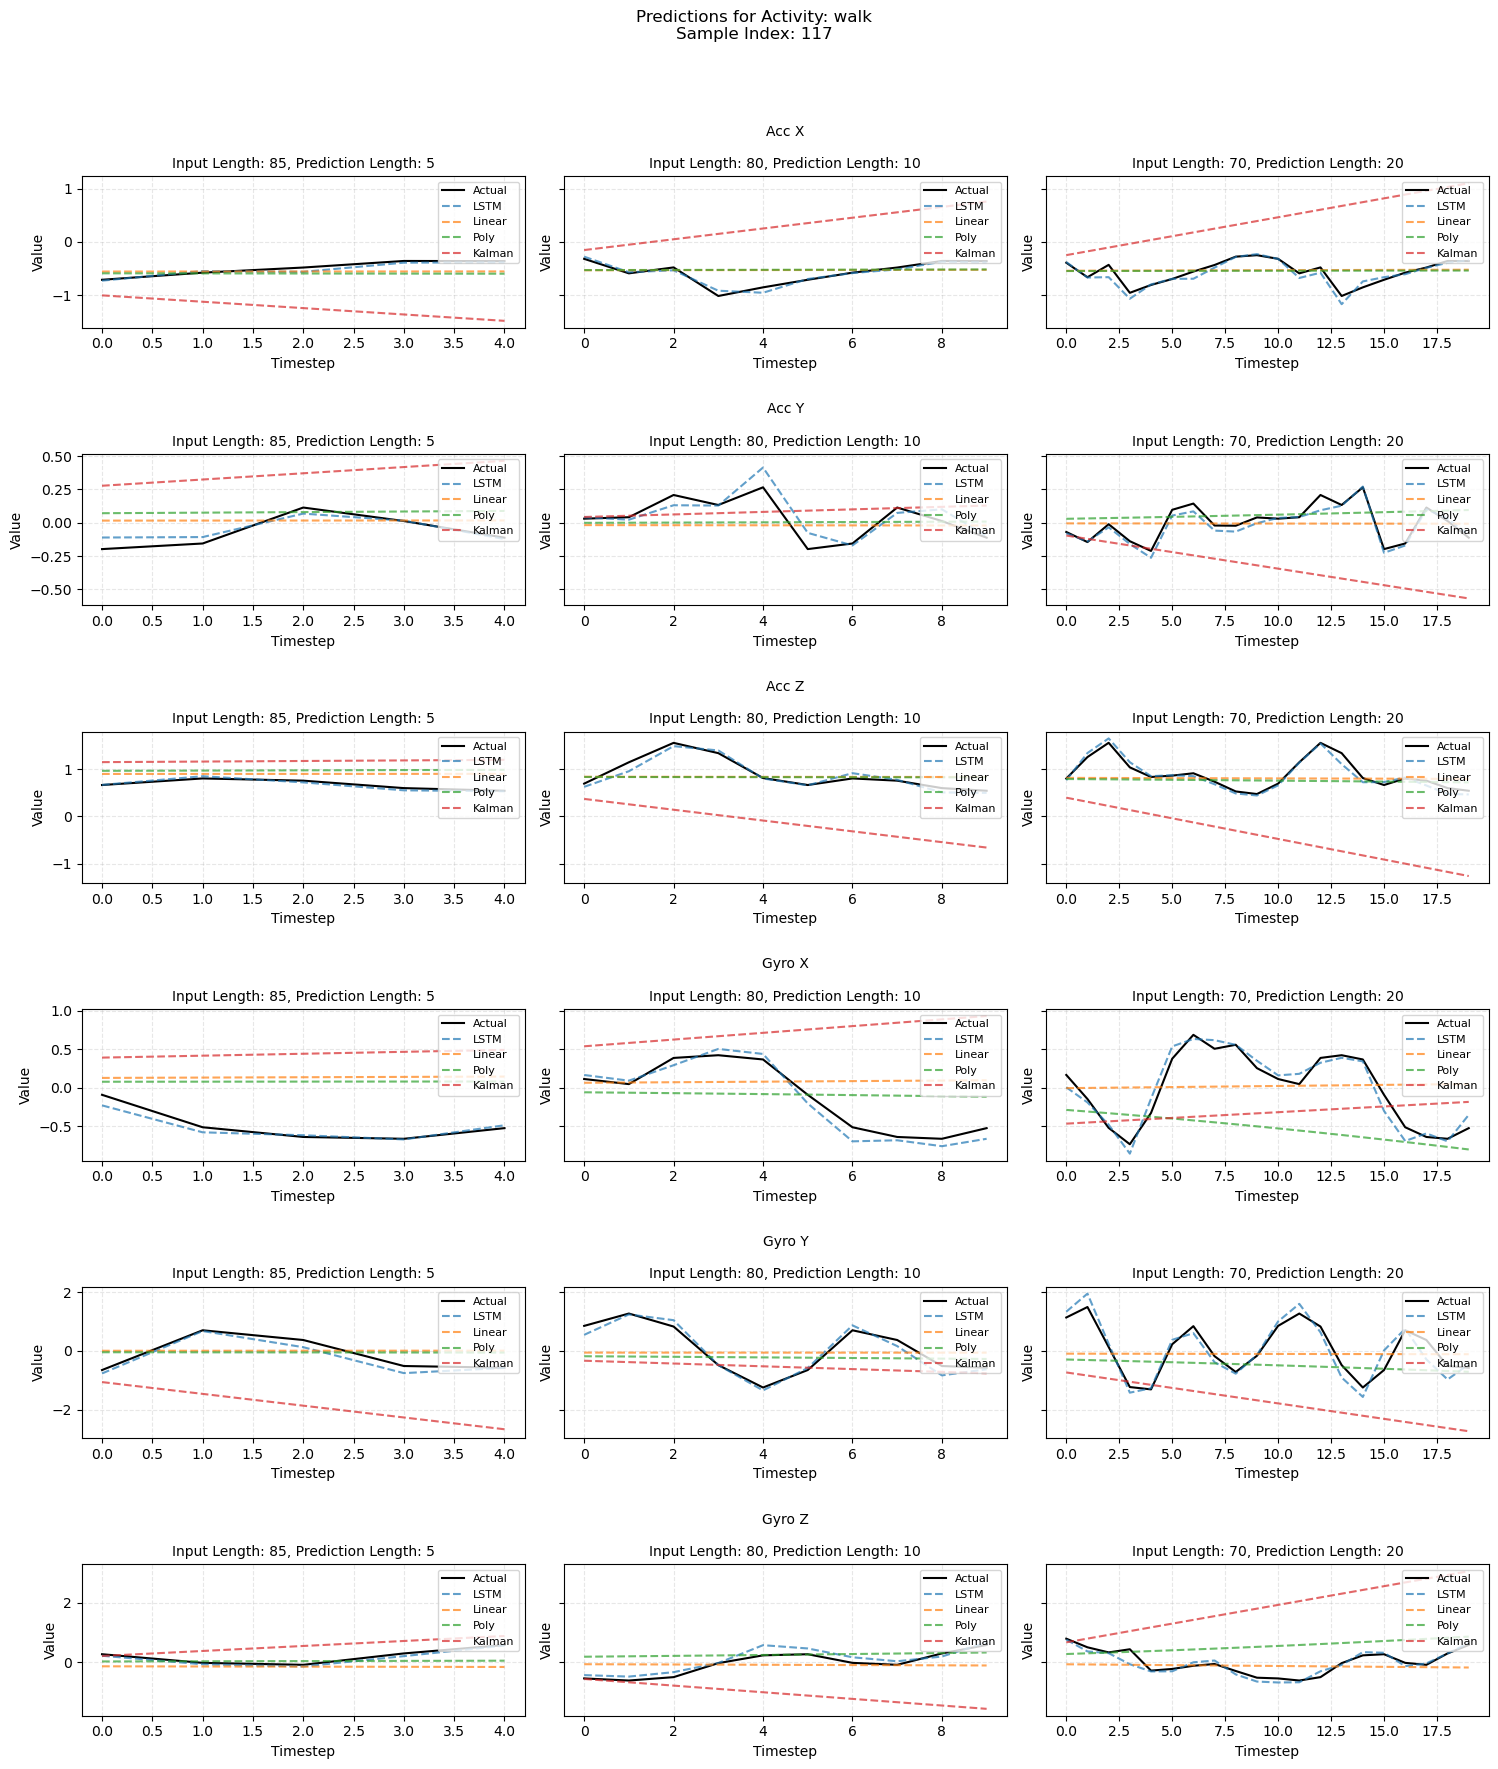

In [11]:
def visualize_sample_predictions(predictions, all_actuals, all_pair_to_activity, activity_names, input_output_pairs):
    """Plot visualizations of model predictions for each activity type across different configurations."""

    os.makedirs("baseline_plots/predictions", exist_ok=True)
    
    features_names = ['Acc X', 'Acc Y', 'Acc Z', 'Gyro X', 'Gyro Y', 'Gyro Z']
    models = list(OrderedDict.fromkeys(k.split("_")[0] for k in predictions.keys()))
    
    # Use first configuration's pair_to_activity to find activities
    first_config = input_output_pairs[0]
    pair_to_activity = all_pair_to_activity[first_config]
    unique_activities = sorted(set(pair_to_activity.values()))
    
    # Find the first sample for each activity
    activity_samples = {}
    for pair_idx, activity in pair_to_activity.items():
        if activity not in activity_samples:
            # Find position in the predictions array
            pred_idx = list(pair_to_activity.keys()).index(pair_idx)
            activity_samples[activity] = pred_idx
    
    # Process each activity
    for activity in unique_activities:
        # Skip if no sample found for this activity
        if activity not in activity_samples:
            print(f"⚠️ No sample found for activity {activity}")
            continue
        
        sample_idx = activity_samples[activity]
        activity_label = activity_names.get(activity, f"Activity {activity}")
        
        print(f"Plotting {activity_label} (ID: {activity}), sample index: {sample_idx}")
        
        # Create figure with 6 rows × N columns (features × configs)
        num_features = len(features_names)
        num_configs = len(input_output_pairs)
        
        fig, axs = plt.subplots(
            num_features, 
            num_configs, 
            figsize=(5 * num_configs, 3 * num_features),
            sharey='row'  # Share y-axis within rows
        )
        
        # Handle case where there's only one input-output pair
        if num_configs == 1:
            axs = axs.reshape(-1, 1)
        
        fig.suptitle(f"Predictions for Activity: {activity_label}\nSample Index: {sample_idx}", fontsize=12)
        
        # Plot data for each feature and configuration
        for row_idx, feature_name in enumerate(features_names):
            for col_idx, config in enumerate(input_output_pairs):
                input_len, pred_len = config
                ax = axs[row_idx, col_idx]
                
                # Get the actuals for this specific configuration
                config_actuals = all_actuals.get(config)
                if config_actuals is None:
                    print(f"Warning: No actuals found for config {config}")
                    continue
                
                # Plot actual values for this configuration
                ax.plot(config_actuals[sample_idx, :, row_idx], 'k-', label='Actual', linewidth=1.5)
                
                # Plot predictions from each model for this configuration
                for model in models:
                    model_key = f"{model}_{input_len}_{pred_len}"
                    if model_key in predictions:
                        try:
                            pred_seq = predictions[model_key][sample_idx, :, row_idx]
                            ax.plot(
                                pred_seq, 
                                linestyle='--',linewidth=1.5,
                                label=model, 
                                alpha=0.7
                            )
                        except (IndexError, KeyError) as e:
                            print(f"Error plotting {model_key}: {e}")
                            continue
                
                    
                    title = f"Input Length: {input_len}, Prediction Length: {pred_len}"
                    if col_idx == 1:
                        title = f'\n{feature_name}\n\n' + title
                    ax.set_title(title, fontsize=10)

                    ax.set_title(title, fontsize=10)
                    ax.set_ylabel("Value", fontsize=10)
                    ax.set_xlabel("Timestep", fontsize=10)
                
                # Add grid and optimize display
                ax.grid(True, linestyle='--', alpha=0.3)
                ax.legend(fontsize=8, loc='upper right')
        
        # Adjust layout
        plt.tight_layout(rect=[0, 0, 1, 0.96])
        
        # Save and display
        filename = f"baseline_plots/predictions/{activity_label.replace(' ', '_')}.png"
        plt.savefig(filename, bbox_inches='tight', dpi=300)
        print(f"Saved plot for {activity_label} to {filename}")
        plt.show()

visualize_sample_predictions(all_predictions, all_actuals, all_pair_to_activity, ACTIVITY_NAMES, INPUT_OUTPUT_PAIRS)

In [12]:
def print_all_model_metrics(all_activity_results, input_output_pairs, activity_names):
    """
    Prints per-activity, per-feature metrics for every model/config in all_activity_results 
    across different configurations
    """
    # Ensure a consistent order
    for model_key in sorted(all_activity_results.keys()):
        base, inp_str, pred_str = model_key.split("_")
        inp, pred = int(inp_str), int(pred_str)

        print(f"\nModel: {base} (Input={inp}, Pred={pred})\n")
        model_data = all_activity_results[model_key]

        # for each activity id in order
        for act_id in sorted(model_data.keys()):
            act_data = model_data[act_id]
            activity_name = activity_names.get(act_id, f"Activity {act_id}")
            print(f"\tActivity: {activity_name}")

            mse_line     = "  - MSE     : " + "  ".join(f"{v:.4f}" for v in act_data['mse'])
            mape_line    = "  - MAPE    : " + "  ".join(f"{v:.2f}" for v in act_data['mape'])
            pearson_line = "  - Pearson : " + "  ".join(f"{v:.4f}" for v in act_data['pearson'])

            print("\t",mse_line)
            print("\t",mape_line)
            print("\t",pearson_line)
            print() 

print_all_model_metrics(all_activity_results,INPUT_OUTPUT_PAIRS,ACTIVITY_NAMES)


Model: Kalman (Input=70, Pred=20)

	Activity: bike
	   - MSE     : 0.2027  0.3688  0.4460  10.1705  4.2274  1.7628
	   - MAPE    : 212912747.30  1698.20  52.31  1713.15  22561704.93  1561.16
	   - Pearson : 0.3617  -0.0254  0.0245  -0.0318  -0.0098  -0.0742

	Activity: sit
	   - MSE     : 0.0007  0.0006  0.0009  0.0020  0.0102  0.0145
	   - MAPE    : 9.71  84.23  1.60  3378792941255503.00  12807924871311382.00  1276617024891865.75
	   - Pearson : 0.9957  0.9585  0.9852  0.2848  0.0783  0.4216

	Activity: downstairs
	   - MSE     : 0.9526  0.4246  1.9129  2.0315  4.9948  4.5551
	   - MAPE    : 936.23  1388.42  125.36  1956.03  1933.80  1287.91
	   - Pearson : 0.1924  -0.0175  0.0051  0.1789  -0.0079  0.2743

	Activity: upstairs
	   - MSE     : 0.8360  0.5275  1.0551  6.5782  5.1286  3.0727
	   - MAPE    : 254.69  1629.47  100.78  1493.62  2277.69  1937.88
	   - Pearson : 0.1762  -0.0420  0.0013  -0.0380  -0.0149  0.2798

	Activity: stand
	   - MSE     : 0.0004  0.0007  0.0004  0.0026  

In [13]:
def print_all_model_overall_metrics(all_metrics, input_output_pairs):
    """
    Prints the overall metrics for each model/config in all_metrics
    whose (input_len, pred_len) is in input_output_pairs.
    """
    # Ensure a consistent order
    for model_key in sorted(all_metrics.keys()):
        # split “LSTM_85_5” → base="LSTM", inp="85", pred="5"
        base, inp_str, pred_str = model_key.split("_")
        inp, pred = int(inp_str), int(pred_str)

        # skip any unexpected pairs
        if (inp, pred) not in input_output_pairs:
            continue

        print(f"\nModel: {base} (Input={inp}, Pred={pred})\n")

        model_data = all_metrics[model_key]
        
        overall_mse = model_data['overall_mse']
        overall_mape = model_data['overall_mape']
        overall_pearson = model_data['overall_pearson']

        print(f"  - Overall MSE          : {overall_mse:.4f}")
        print(f"  - Overall MAPE         : {overall_mape:.2f}")
        print(f"  - Overall Pearson Correlation : {overall_pearson:.4f}")
        print()

        mse_line     = "  - MSE     : " + "  ".join(f"{v:.4f}" for v in model_data['mse'])
        mape_line    = "  - MAPE    : " + "  ".join(f"{v:.2f}" for v in model_data['mape'])
        pearson_line = "  - Pearson : " + "  ".join(f"{v:.4f}" for v in model_data['pearson'])

        print(mse_line)
        print(mape_line)
        print(pearson_line)
        print()  # blank line between models
print_all_model_overall_metrics(all_metrics, INPUT_OUTPUT_PAIRS)


Model: Kalman (Input=70, Pred=20)

  - Overall MSE          : 1.5677
  - Overall MAPE         : 673986879821365.75
  - Overall Pearson Correlation : 0.2472

  - MSE     : 0.4824  0.2712  0.8600  3.1244  2.6655  2.0024
  - MAPE    : 69545042.76  4633755.98  66.55  782418074935538.62  2965896953942577.50  295595734614445.44
  - Pearson : 0.4413  0.0029  0.0251  -0.0246  -0.0224  0.1720


Model: Kalman (Input=80, Pred=10)

  - Overall MSE          : 0.6253
  - Overall MAPE         : 21563227.36
  - Overall Pearson Correlation : 0.4111

  - MSE     : 0.1975  0.1078  0.3456  1.2755  1.0838  0.7415
  - MAPE    : 43997203.67  892.27  44.20  24640170.75  16519215.81  44223088.00
  - Pearson : 0.6098  0.1213  0.0451  0.0791  -0.0278  0.3615


Model: Kalman (Input=85, Pred=5)

  - Overall MSE          : 0.2989
  - Overall MAPE         : 14769437.32
  - Overall Pearson Correlation : 0.5875

  - MSE     : 0.1174  0.0482  0.2078  0.4564  0.6370  0.3268
  - MAPE    : 24499914.95  747.00  33.54  653